In [1]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.applications.vgg19 import VGG19
from keras.applications import Xception
from keras.applications import ResNet50V2
from keras.applications import ResNet101
from keras.applications import ResNet152
from keras.applications import InceptionV3
from keras.applications import InceptionResNetV2
from keras.applications import MobileNet
from keras.applications import DenseNet121
from keras.applications import DenseNet201
from keras.applications import EfficientNetB0
from keras.applications import EfficientNetV2B0
from keras.applications import ConvNeXtTiny

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [4]:
dataset_iphone = cargar_datos('Datos EMD/iPhone/EMD', 'Datos EMD/iPhone/NO EMD')

dataset_samsung = cargar_datos('Datos EMD/Samsung/EMD', 'Datos EMD/Samsung/NO EMD')

dataset = cargar_datos('Datos EMD/OCT/EMD', 'Datos EMD/OCT/NO EMD')

In [5]:
def trasnferLearning_classweight(test, red):
    
    #Definir conjuntos de datos train y test
    
    if test=='iphone':
        
        train_ds = np.concatenate((dataset[0],dataset_samsung[0]))
        train_labels = np.concatenate((dataset[1],dataset_samsung[1]))
        
        test_ds = dataset_iphone[0]
        test_labels = dataset_iphone[1]
        
    elif test=='samsung':
        
        train_ds = np.concatenate((dataset[0],dataset_iphone[0]))
        train_labels = np.concatenate((dataset[1],dataset_iphone[1]))

        test_ds = dataset_samsung[0]
        test_labels = dataset_samsung[1]
    
    train_labels_categorical = to_categorical(train_labels, num_classes=2)
    test_labels_categorical = to_categorical(test_labels, num_classes=2)
    
    #Definir modelo de trasnfer learning
    base_model = red(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
    base_model.trainable = False ## Not trainable weights

    #Preprocessing input
    train_ds = preprocess_input(train_ds) 
    test_ds = preprocess_input(test_ds)
    
    #Definir fine tunning
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(50, activation='relu')
    dense_layer_2 = layers.Dense(20, activation='relu')
    prediction_layer = layers.Dense(2, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer_1,
        dense_layer_2,
        prediction_layer
    ])
    
    #Definir compensador de pesos
    classes = np.unique(train_labels)
    class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)
    dic_class_weights = {0:class_weights[0], 1:class_weights[1]}
    
    #Entrenar el modelo
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

    history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)
    
    #Métricas de evaluación
    score_test = model.evaluate(x=test_ds, y=test_labels_categorical, verbose = 0)
    print("Test loss:", score_test[0])
    print("Test accuracy:", score_test[1])
    
    predictions = model.predict(test_ds)
    roc_score = roc_auc_score(test_labels_categorical, predictions, multi_class='ovr')
    print("AUC score:", roc_score)
    
    labels_predict = []
    for e in predictions:
        if e[0]>e[1]:
            labels_predict.append(0)
        else:
            labels_predict.append(1)
        
    f1 = f1_score(test_labels, labels_predict, average='weighted')
    print("f1-score", f1)
    
    matriz = confusion_matrix(test_labels, labels_predict)
    print("Matriz de confusión", matriz)
    
    return history

## VGG16

In [6]:
history_vgg16 = trasnferLearning_classweight('iphone', VGG16)

Epoch 1/200
6/6 [==============================] - 8s 1s/step - loss: 1.9902 - accuracy: 0.5763 - val_loss: 4.0576 - val_accuracy: 0.1556
Epoch 2/200
6/6 [==============================] - 6s 1s/step - loss: 0.6493 - accuracy: 0.7684 - val_loss: 3.3577 - val_accuracy: 0.1778
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 0.3947 - accuracy: 0.8531 - val_loss: 3.8417 - val_accuracy: 0.2000
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 0.2313 - accuracy: 0.8983 - val_loss: 2.1596 - val_accuracy: 0.3333
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 0.1367 - accuracy: 0.9435 - val_loss: 2.3567 - val_accuracy: 0.3111
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 0.1124 - accuracy: 0.9661 - val_loss: 2.9200 - val_accuracy: 0.2667
Epoch 7/200
6/6 [==============================] - 8s 1s/step - loss: 0.0892 - accuracy: 0.9605 - val_loss: 3.8932 - val_accuracy: 0.2667
Epoch 8/200
6/6 [=================

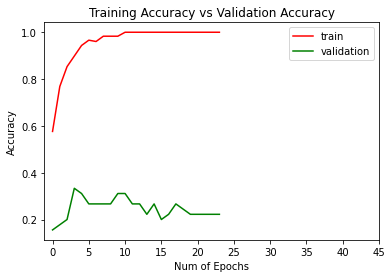

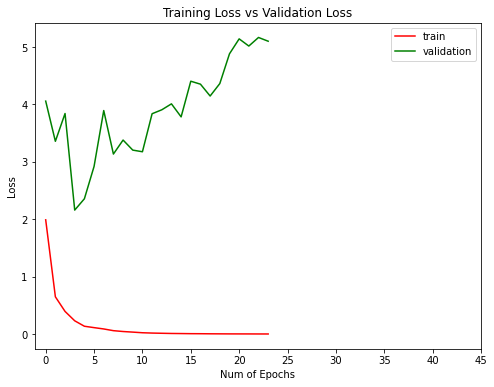

In [7]:
plt.figure(0)  
plt.plot(history_vgg16.history['accuracy'],'r')  
plt.plot(history_vgg16.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_vgg16.history['loss'],'r')  
plt.plot(history_vgg16.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

In [ ]:
acc      = history_vgg16.history['accuracy']
val_acc  = history_vgg16.history['val_accuracy']
loss     = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [8]:
history_vgg16_bis = trasnferLearning_classweight('samsung', VGG16)

Epoch 1/200
6/6 [==============================] - 10s 2s/step - loss: 9.0839 - accuracy: 0.6099 - val_loss: 6.0893 - val_accuracy: 0.4565
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 2.2024 - accuracy: 0.6703 - val_loss: 1.8938 - val_accuracy: 0.7391
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 2.3962 - accuracy: 0.7912 - val_loss: 9.3040 - val_accuracy: 0.2391
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 1.9633 - accuracy: 0.5604 - val_loss: 4.4807 - val_accuracy: 0.4565
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 1.1374 - accuracy: 0.8901 - val_loss: 3.3805 - val_accuracy: 0.5870
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 0.5632 - accuracy: 0.8297 - val_loss: 9.3243 - val_accuracy: 0.2391
Epoch 7/200
6/6 [==============================] - 8s 1s/step - loss: 0.2253 - accuracy: 0.8516 - val_loss: 1.9391 - val_accuracy: 0.7609
Epoch 8/200
6/6 [================

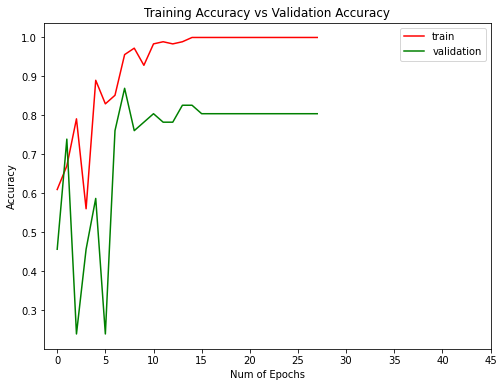

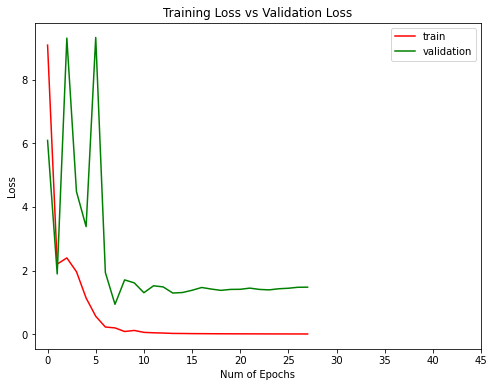

In [9]:
plt.figure(0)  
plt.plot(history_vgg16_bis.history['accuracy'],'r')  
plt.plot(history_vgg16_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_vgg16_bis.history['loss'],'r')  
plt.plot(history_vgg16_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

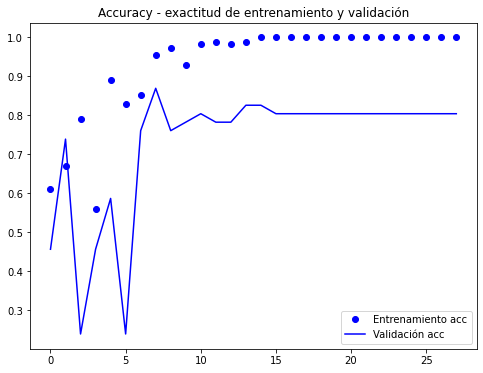

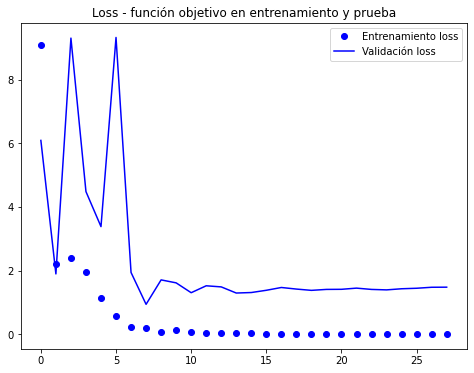

In [10]:
acc      = history_vgg16_bis.history['accuracy']
val_acc  = history_vgg16_bis.history['val_accuracy']
loss     = history_vgg16_bis.history['loss']
val_loss = history_vgg16_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## VGG19

In [11]:
history_vgg19 = trasnferLearning_classweight('iphone', VGG19)

Epoch 1/200
6/6 [==============================] - 11s 2s/step - loss: 7.5677 - accuracy: 0.5593 - val_loss: 3.3567 - val_accuracy: 0.3556
Epoch 2/200
6/6 [==============================] - 10s 2s/step - loss: 1.5945 - accuracy: 0.6610 - val_loss: 8.4842 - val_accuracy: 0.0444
Epoch 3/200
6/6 [==============================] - 10s 2s/step - loss: 1.2730 - accuracy: 0.8362 - val_loss: 11.2094 - val_accuracy: 0.0444
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.3261 - accuracy: 0.8814 - val_loss: 4.1107 - val_accuracy: 0.2222
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.2542 - accuracy: 0.8644 - val_loss: 4.9663 - val_accuracy: 0.1778
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.1479 - accuracy: 0.9548 - val_loss: 9.8531 - val_accuracy: 0.0444
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.0749 - accuracy: 0.9661 - val_loss: 6.4771 - val_accuracy: 0.0889
Epoch 8/200
6/6 [=========

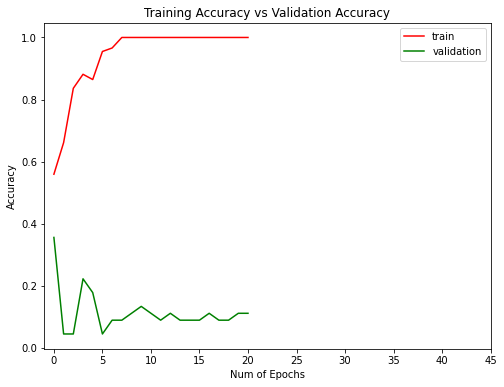

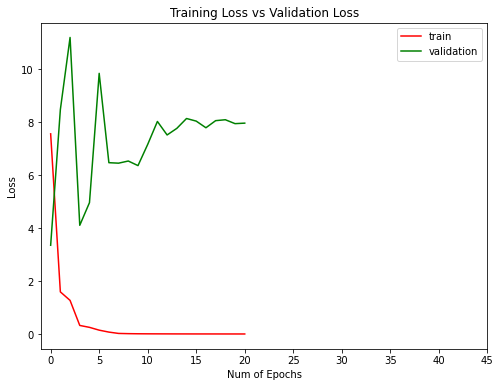

In [12]:
plt.figure(0)  
plt.plot(history_vgg19.history['accuracy'],'r')  
plt.plot(history_vgg19.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_vgg19.history['loss'],'r')  
plt.plot(history_vgg19.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

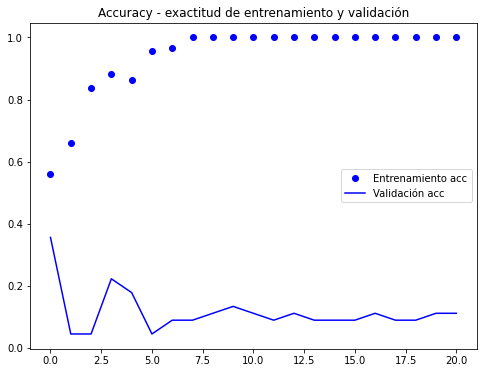

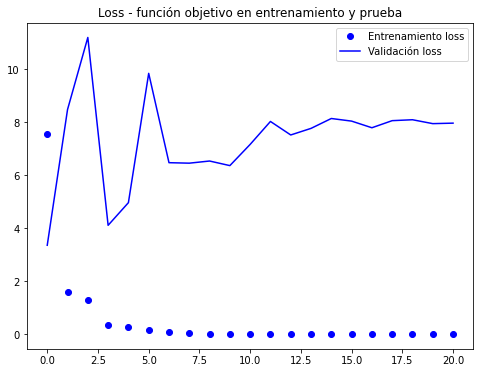

In [13]:
acc      = history_vgg19.history['accuracy']
val_acc  = history_vgg19.history['val_accuracy']
loss     = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [14]:
history_vgg19 = trasnferLearning_classweight('samsung', VGG19)

Epoch 1/200
6/6 [==============================] - 11s 2s/step - loss: 7.1852 - accuracy: 0.4890 - val_loss: 9.4092 - val_accuracy: 0.0870
Epoch 2/200
6/6 [==============================] - 10s 2s/step - loss: 1.6449 - accuracy: 0.7527 - val_loss: 6.0458 - val_accuracy: 0.1739
Epoch 3/200
6/6 [==============================] - 10s 2s/step - loss: 0.9643 - accuracy: 0.6813 - val_loss: 1.8473 - val_accuracy: 0.4348
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.4014 - accuracy: 0.8681 - val_loss: 1.7345 - val_accuracy: 0.4783
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.2784 - accuracy: 0.8791 - val_loss: 1.2306 - val_accuracy: 0.5652
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.2128 - accuracy: 0.9451 - val_loss: 2.2058 - val_accuracy: 0.3696
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.1610 - accuracy: 0.9121 - val_loss: 0.6805 - val_accuracy: 0.7826
Epoch 8/200
6/6 [==========

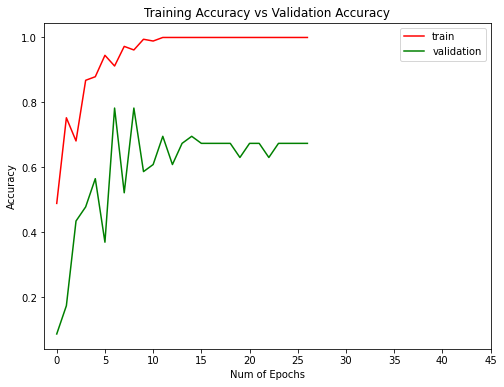

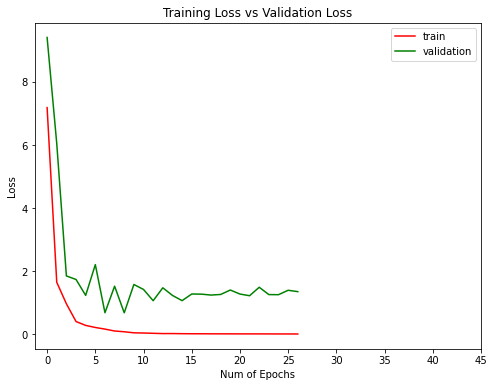

In [15]:
plt.figure(0)  
plt.plot(history_vgg19.history['accuracy'],'r')  
plt.plot(history_vgg19.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_vgg19.history['loss'],'r')  
plt.plot(history_vgg19.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

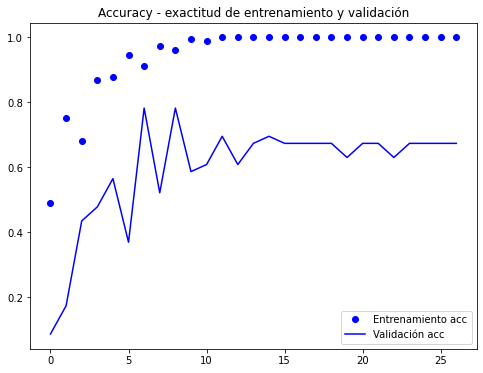

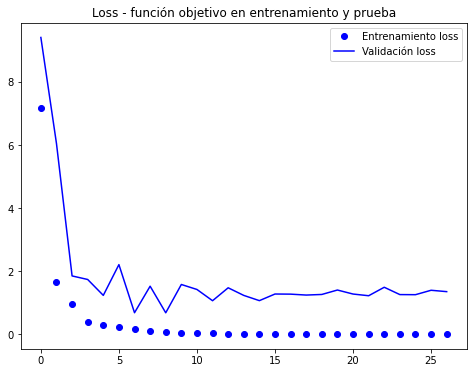

In [16]:
acc      = history_vgg19.history['accuracy']
val_acc  = history_vgg19.history['val_accuracy']
loss     = history_vgg19.history['loss']
val_loss = history_vgg19.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## Xception

In [17]:
history_xception = trasnferLearning_classweight('iphone', Xception)

Epoch 1/200
6/6 [==============================] - 7s 766ms/step - loss: 41.4311 - accuracy: 0.5819 - val_loss: 11.4193 - val_accuracy: 0.0222
Epoch 2/200
6/6 [==============================] - 4s 628ms/step - loss: 2.0035 - accuracy: 0.5424 - val_loss: 9.6515 - val_accuracy: 0.0889
Epoch 3/200
6/6 [==============================] - 4s 602ms/step - loss: 1.4441 - accuracy: 0.7288 - val_loss: 10.8284 - val_accuracy: 0.0000e+00
Epoch 4/200
6/6 [==============================] - 4s 610ms/step - loss: 0.9756 - accuracy: 0.7401 - val_loss: 4.8937 - val_accuracy: 0.0444
Epoch 5/200
6/6 [==============================] - 4s 614ms/step - loss: 0.5291 - accuracy: 0.6949 - val_loss: 2.8425 - val_accuracy: 0.0222
Epoch 6/200
6/6 [==============================] - 4s 624ms/step - loss: 0.4262 - accuracy: 0.7175 - val_loss: 1.3686 - val_accuracy: 0.5556
Epoch 7/200
6/6 [==============================] - 3s 601ms/step - loss: 0.4760 - accuracy: 0.7740 - val_loss: 2.1237 - val_accuracy: 0.3556
Epoch 

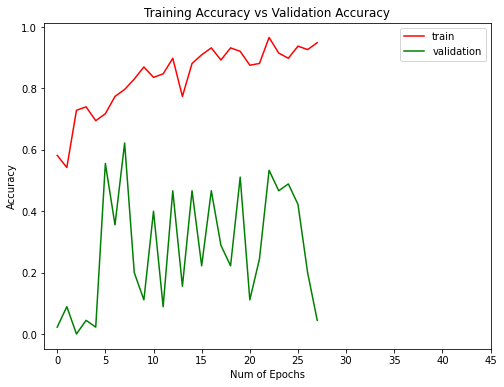

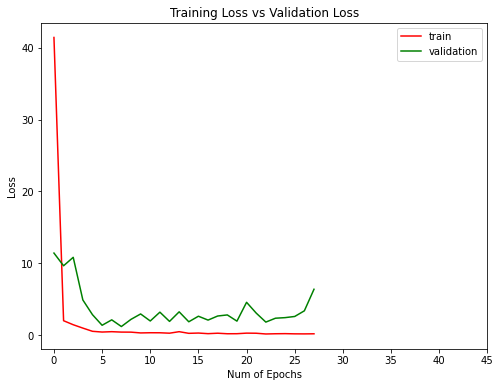

In [18]:
plt.figure(0)  
plt.plot(history_xception.history['accuracy'],'r')  
plt.plot(history_xception.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_xception.history['loss'],'r')  
plt.plot(history_xception.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

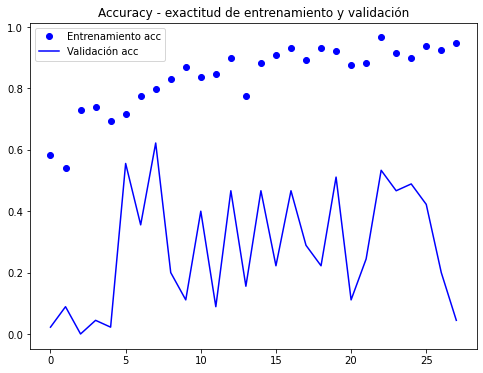

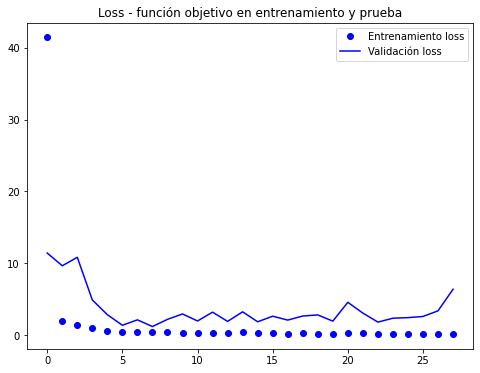

In [19]:
acc      = history_xception.history['accuracy']
val_acc  = history_xception.history['val_accuracy']
loss     = history_xception.history['loss']
val_loss = history_xception.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [20]:
history_xception_bis = trasnferLearning_classweight('samsung', Xception)

Epoch 1/200
6/6 [==============================] - 7s 749ms/step - loss: 36.2118 - accuracy: 0.5165 - val_loss: 83.5539 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 4s 612ms/step - loss: 15.8461 - accuracy: 0.5934 - val_loss: 54.3596 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 4s 621ms/step - loss: 14.0779 - accuracy: 0.4121 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/200
6/6 [==============================] - 4s 601ms/step - loss: 14.6521 - accuracy: 0.7253 - val_loss: 65.2813 - val_accuracy: 0.0217
Epoch 5/200
6/6 [==============================] - 3s 600ms/step - loss: 10.7528 - accuracy: 0.6484 - val_loss: 27.8431 - val_accuracy: 0.0652
Epoch 6/200
6/6 [==============================] - 3s 602ms/step - loss: 8.2572 - accuracy: 0.5275 - val_loss: 5.1585e-04 - val_accuracy: 1.0000
Epoch 7/200
6/6 [==============================] - 4s 608ms/step - loss: 6.7865 - accuracy: 0.5989 - val_loss: 1.4583 - val_accur

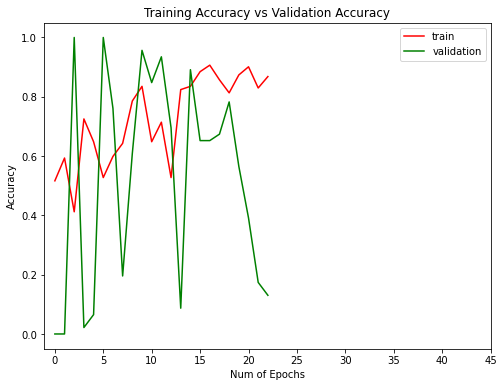

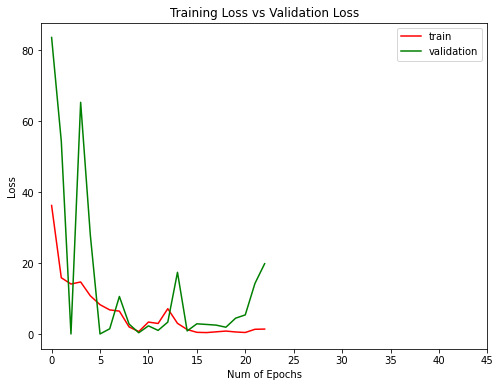

In [21]:
plt.figure(0)  
plt.plot(history_xception_bis.history['accuracy'],'r')  
plt.plot(history_xception_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_xception_bis.history['loss'],'r')  
plt.plot(history_xception_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

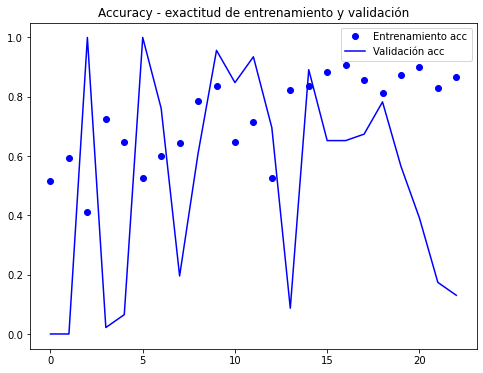

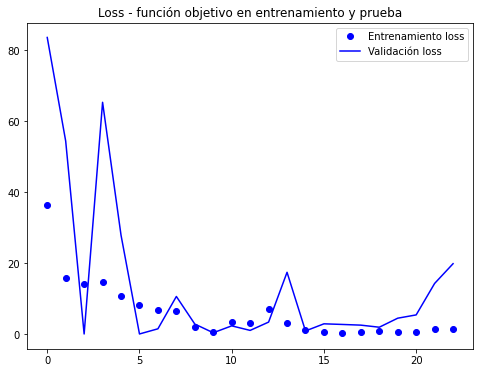

In [22]:
acc      = history_xception_bis.history['accuracy']
val_acc  = history_xception_bis.history['val_accuracy']
loss     = history_xception_bis.history['loss']
val_loss = history_xception_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## ResNet50V2

In [23]:
history_resnet50v2 = trasnferLearning_classweight('samsung', ResNet50V2)

Epoch 1/200
6/6 [==============================] - 7s 728ms/step - loss: 2070.8694 - accuracy: 0.4176 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/200
6/6 [==============================] - 3s 569ms/step - loss: 1022.9187 - accuracy: 0.5549 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/200
6/6 [==============================] - 3s 594ms/step - loss: 696.9349 - accuracy: 0.5275 - val_loss: 604.7952 - val_accuracy: 0.0217
Epoch 4/200
6/6 [==============================] - 3s 566ms/step - loss: 410.0085 - accuracy: 0.6264 - val_loss: 88.7803 - val_accuracy: 0.5000
Epoch 5/200
6/6 [==============================] - 3s 597ms/step - loss: 499.9099 - accuracy: 0.4670 - val_loss: 714.4249 - val_accuracy: 0.0217
Epoch 6/200
6/6 [==============================] - 3s 569ms/step - loss: 534.6810 - accuracy: 0.4835 - val_loss: 976.8390 - val_accuracy: 0.0217
Epoch 7/200
6/6 [==============================] - 3s 597ms/step - loss: 399.0602 - accuracy: 0.5165 - val_loss: 0.0000e+00 -

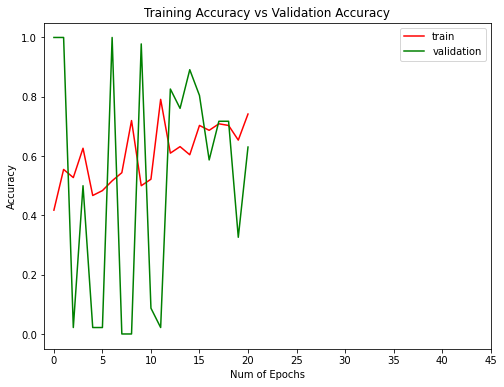

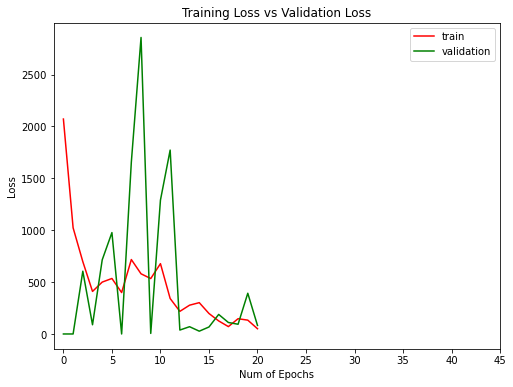

In [24]:
plt.figure(0)  
plt.plot(history_resnet50v2.history['accuracy'],'r')  
plt.plot(history_resnet50v2.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_resnet50v2.history['loss'],'r')  
plt.plot(history_resnet50v2.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

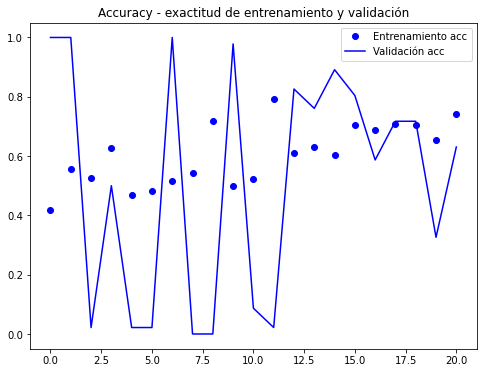

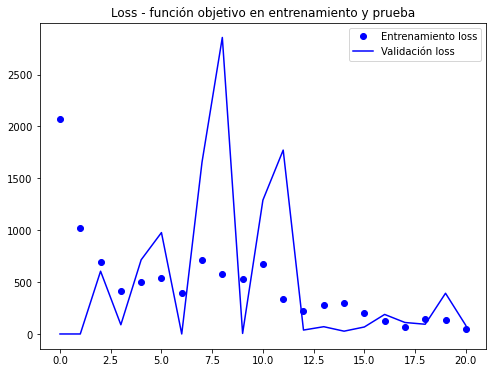

In [25]:
acc      = history_resnet50v2.history['accuracy']
val_acc  = history_resnet50v2.history['val_accuracy']
loss     = history_resnet50v2.history['loss']
val_loss = history_resnet50v2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [26]:
history_resnet50v2_bis = trasnferLearning_classweight('iphone', ResNet50V2)

Epoch 1/200
6/6 [==============================] - 7s 675ms/step - loss: 1728.7074 - accuracy: 0.4746 - val_loss: 1380.3059 - val_accuracy: 0.0444
Epoch 2/200
6/6 [==============================] - 3s 544ms/step - loss: 443.6396 - accuracy: 0.6610 - val_loss: 3712.3396 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 3s 556ms/step - loss: 519.0186 - accuracy: 0.6215 - val_loss: 673.4286 - val_accuracy: 0.2000
Epoch 4/200
6/6 [==============================] - 3s 566ms/step - loss: 382.5864 - accuracy: 0.7062 - val_loss: 3844.9819 - val_accuracy: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 3s 550ms/step - loss: 470.6205 - accuracy: 0.7740 - val_loss: 665.8829 - val_accuracy: 0.0667
Epoch 6/200
6/6 [==============================] - 3s 565ms/step - loss: 296.9520 - accuracy: 0.6723 - val_loss: 374.8651 - val_accuracy: 0.0000e+00
Epoch 7/200
6/6 [==============================] - 3s 544ms/step - loss: 227.1460 - accuracy: 0.6554 - val_loss: 4

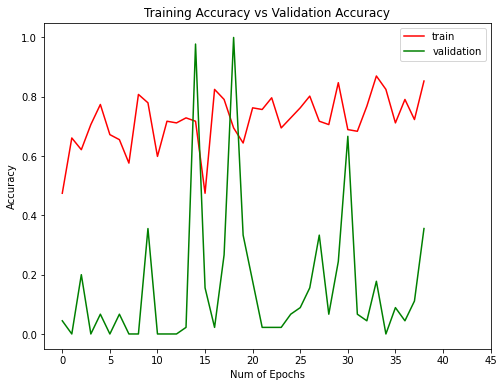

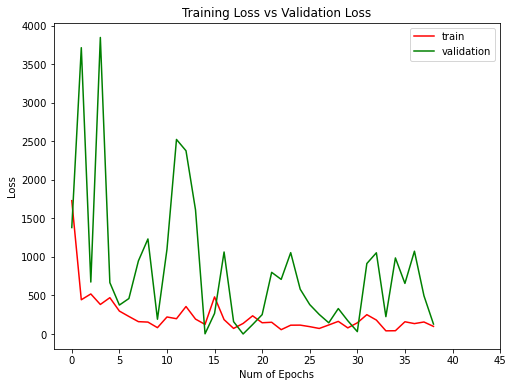

In [27]:
plt.figure(0)  
plt.plot(history_resnet50v2_bis.history['accuracy'],'r')  
plt.plot(history_resnet50v2_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_resnet50v2_bis.history['loss'],'r')  
plt.plot(history_resnet50v2_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

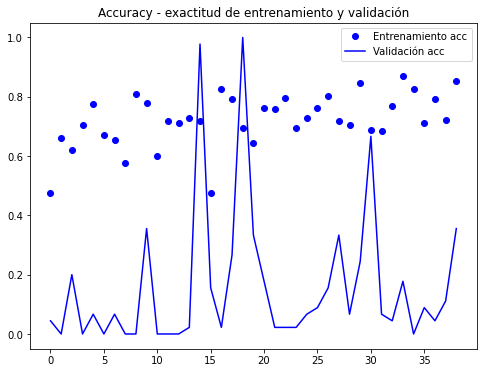

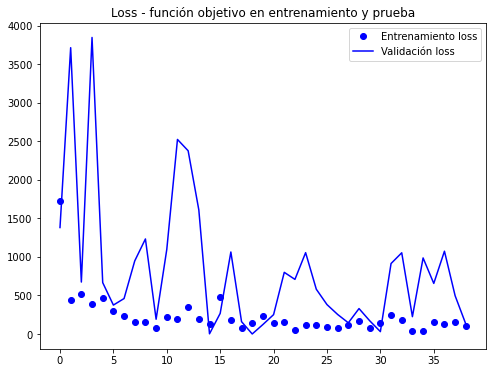

In [28]:
acc      = history_resnet50v2_bis.history['accuracy']
val_acc  = history_resnet50v2_bis.history['val_accuracy']
loss     = history_resnet50v2_bis.history['loss']
val_loss = history_resnet50v2_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## ResNet101

In [29]:
history_resnet101 = trasnferLearning_classweight('iphone', ResNet101)

Epoch 1/200
6/6 [==============================] - 14s 1s/step - loss: 2.1898 - accuracy: 0.4859 - val_loss: 8.7888 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 7s 1s/step - loss: 2.6640 - accuracy: 0.8136 - val_loss: 15.5886 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 7s 1s/step - loss: 0.7885 - accuracy: 0.7514 - val_loss: 3.7770 - val_accuracy: 0.2000
Epoch 4/200
6/6 [==============================] - 7s 1s/step - loss: 0.4232 - accuracy: 0.7910 - val_loss: 5.7898 - val_accuracy: 0.1778
Epoch 5/200
6/6 [==============================] - 7s 1s/step - loss: 0.5374 - accuracy: 0.9322 - val_loss: 13.0348 - val_accuracy: 0.0222
Epoch 6/200
6/6 [==============================] - 7s 1s/step - loss: 0.2790 - accuracy: 0.8475 - val_loss: 6.2712 - val_accuracy: 0.1333
Epoch 7/200
6/6 [==============================] - 7s 1s/step - loss: 0.2066 - accuracy: 0.9435 - val_loss: 9.8825 - val_accuracy: 0.0667
Epoch 8/200
6/6 [======

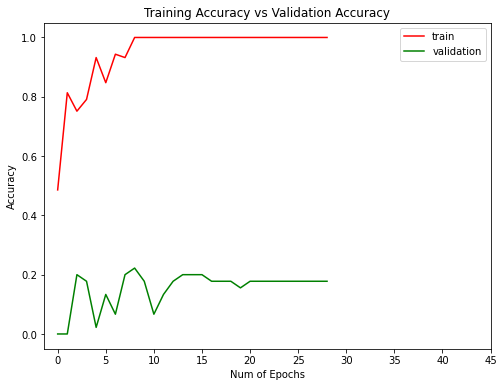

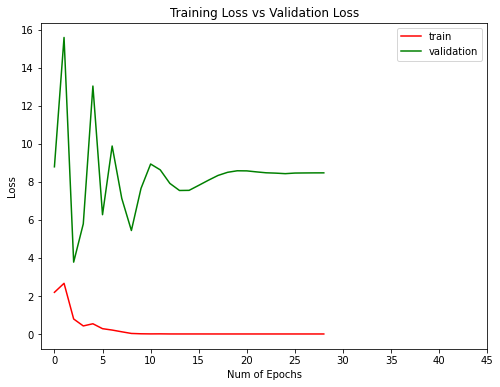

In [30]:
plt.figure(0)  
plt.plot(history_resnet101.history['accuracy'],'r')  
plt.plot(history_resnet101.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_resnet101.history['loss'],'r')  
plt.plot(history_resnet101.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

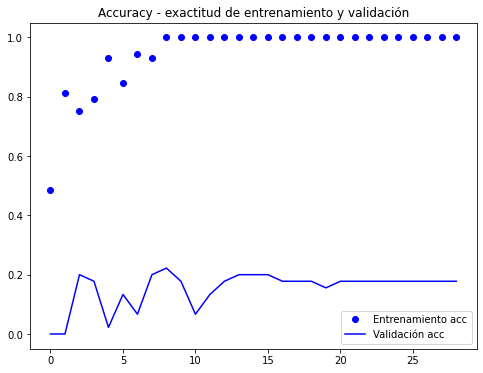

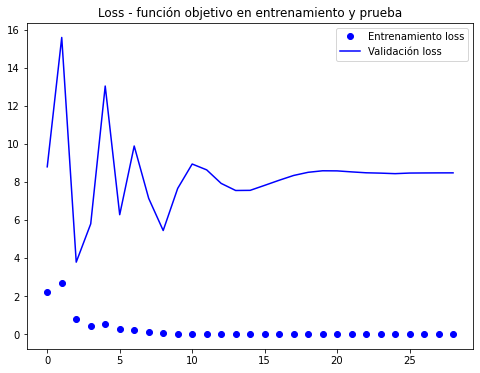

In [31]:
acc      = history_resnet101.history['accuracy']
val_acc  = history_resnet101.history['val_accuracy']
loss     = history_resnet101.history['loss']
val_loss = history_resnet101.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [32]:
history_resnet101_bis = trasnferLearning_classweight('samsung', ResNet101)

Epoch 1/200
6/6 [==============================] - 14s 2s/step - loss: 6.0520 - accuracy: 0.4835 - val_loss: 19.4090 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 7s 1s/step - loss: 5.1226 - accuracy: 0.3791 - val_loss: 0.1369 - val_accuracy: 0.9130
Epoch 3/200
6/6 [==============================] - 7s 1s/step - loss: 1.9598 - accuracy: 0.7912 - val_loss: 9.5312 - val_accuracy: 0.0000e+00
Epoch 4/200
6/6 [==============================] - 7s 1s/step - loss: 0.6345 - accuracy: 0.7967 - val_loss: 0.1308 - val_accuracy: 0.9565
Epoch 5/200
6/6 [==============================] - 7s 1s/step - loss: 0.3822 - accuracy: 0.8681 - val_loss: 2.5711 - val_accuracy: 0.4130
Epoch 6/200
6/6 [==============================] - 7s 1s/step - loss: 0.1623 - accuracy: 0.9396 - val_loss: 0.3611 - val_accuracy: 0.8478
Epoch 7/200
6/6 [==============================] - 7s 1s/step - loss: 0.0339 - accuracy: 0.9945 - val_loss: 0.9320 - val_accuracy: 0.6739
Epoch 8/200
6/6 [=======

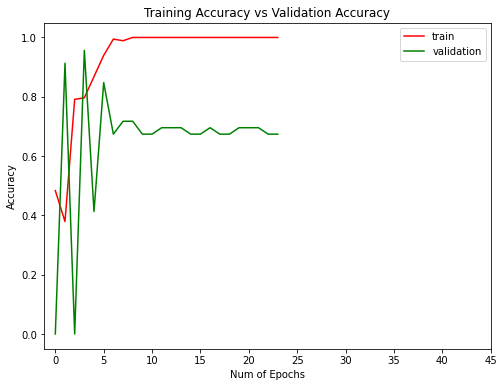

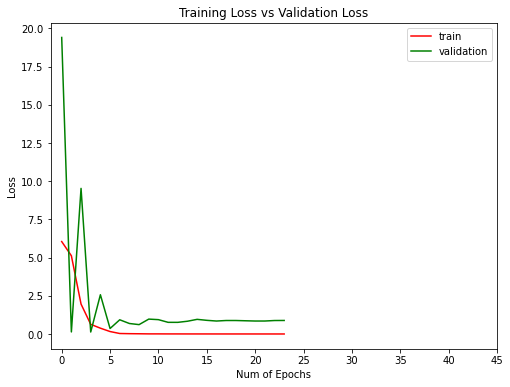

In [33]:
plt.figure(0)  
plt.plot(history_resnet101_bis.history['accuracy'],'r')  
plt.plot(history_resnet101_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_resnet101_bis.history['loss'],'r')  
plt.plot(history_resnet101_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

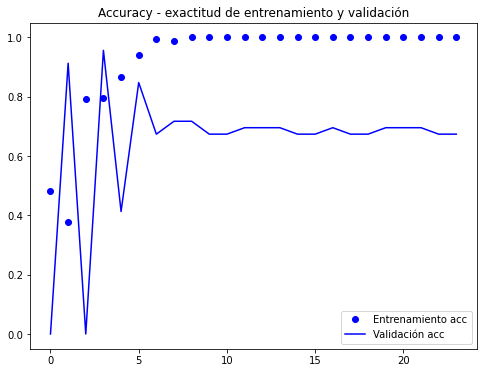

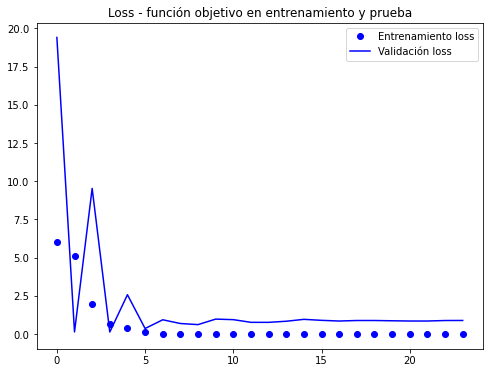

In [34]:
acc      = history_resnet101_bis.history['accuracy']
val_acc  = history_resnet101_bis.history['val_accuracy']
loss     = history_resnet101_bis.history['loss']
val_loss = history_resnet101_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## ResNet152

In [35]:
history_resnet152 = trasnferLearning_classweight('iphone', ResNet152)

Epoch 1/200
6/6 [==============================] - 22s 2s/step - loss: 3.6846 - accuracy: 0.5593 - val_loss: 12.4778 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 11s 2s/step - loss: 1.5132 - accuracy: 0.8192 - val_loss: 6.8273 - val_accuracy: 0.0889
Epoch 3/200
6/6 [==============================] - 11s 2s/step - loss: 0.5719 - accuracy: 0.8362 - val_loss: 9.3052 - val_accuracy: 0.0222
Epoch 4/200
6/6 [==============================] - 10s 2s/step - loss: 0.2418 - accuracy: 0.9266 - val_loss: 9.0566 - val_accuracy: 0.0444
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 0.1635 - accuracy: 0.9492 - val_loss: 10.7576 - val_accuracy: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 10s 2s/step - loss: 0.0224 - accuracy: 0.9887 - val_loss: 3.1532 - val_accuracy: 0.3778
Epoch 7/200
6/6 [==============================] - 10s 2s/step - loss: 0.0727 - accuracy: 0.9661 - val_loss: 7.8716 - val_accuracy: 0.0444
Epoch 8/200
6/6 [

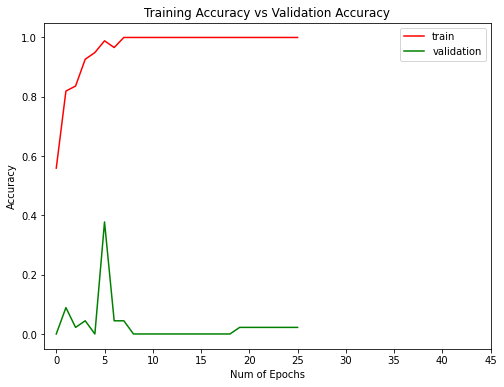

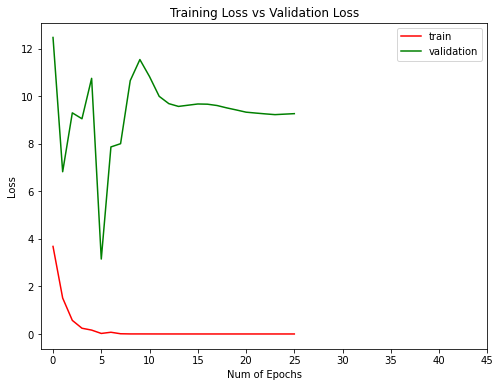

In [36]:
plt.figure(0)  
plt.plot(history_resnet152.history['accuracy'],'r')  
plt.plot(history_resnet152.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_resnet152.history['loss'],'r')  
plt.plot(history_resnet152.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

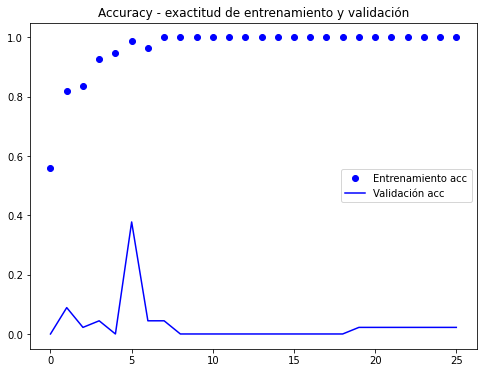

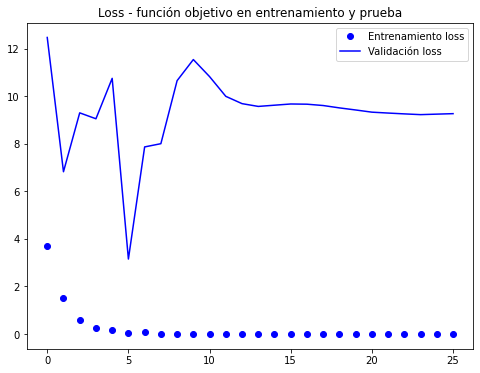

In [37]:
acc      = history_resnet152.history['accuracy']
val_acc  = history_resnet152.history['val_accuracy']
loss     = history_resnet152.history['loss']
val_loss = history_resnet152.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [38]:
history_resnet152_bis = trasnferLearning_classweight('samsung', ResNet152)

Epoch 1/200
6/6 [==============================] - 25s 3s/step - loss: 3.8074 - accuracy: 0.5220 - val_loss: 10.9577 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 12s 2s/step - loss: 1.8548 - accuracy: 0.5055 - val_loss: 3.5654 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 12s 2s/step - loss: 0.8795 - accuracy: 0.6319 - val_loss: 3.0788 - val_accuracy: 0.1304
Epoch 4/200
6/6 [==============================] - 12s 2s/step - loss: 0.8468 - accuracy: 0.6868 - val_loss: 0.6390 - val_accuracy: 0.8043
Epoch 5/200
6/6 [==============================] - 13s 2s/step - loss: 0.8548 - accuracy: 0.8242 - val_loss: 0.8822 - val_accuracy: 0.7391
Epoch 6/200
6/6 [==============================] - 12s 2s/step - loss: 0.3464 - accuracy: 0.8736 - val_loss: 1.7903 - val_accuracy: 0.6087
Epoch 7/200
6/6 [==============================] - 12s 2s/step - loss: 0.1596 - accuracy: 0.9066 - val_loss: 1.6354 - val_accuracy: 0.5870
Epoch 8/200
6/6 [=

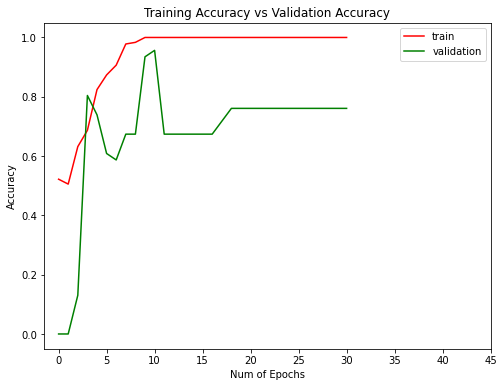

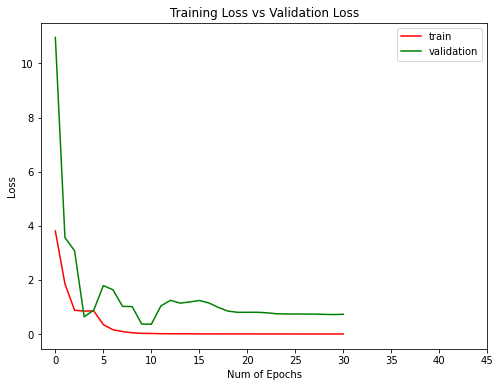

In [39]:
plt.figure(0)  
plt.plot(history_resnet152_bis.history['accuracy'],'r')  
plt.plot(history_resnet152_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_resnet152_bis.history['loss'],'r')  
plt.plot(history_resnet152_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

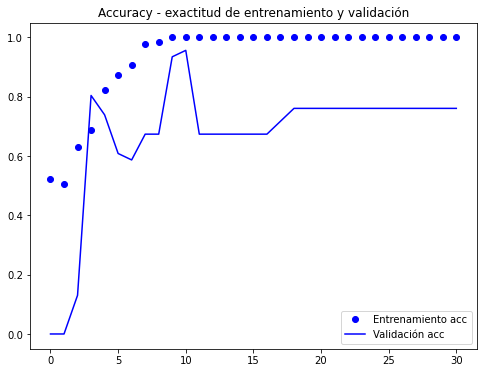

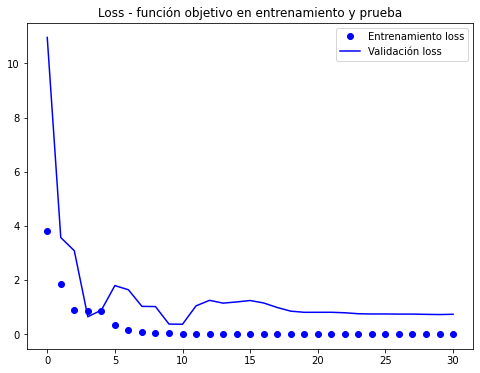

In [40]:
acc      = history_resnet152_bis.history['accuracy']
val_acc  = history_resnet152_bis.history['val_accuracy']
loss     = history_resnet152_bis.history['loss']
val_loss = history_resnet152_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## InceptionV3

In [41]:
history_inceptionv3 = trasnferLearning_classweight('iphone', InceptionV3)

Epoch 1/200
6/6 [==============================] - 7s 515ms/step - loss: 43.4308 - accuracy: 0.5480 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/200
6/6 [==============================] - 2s 276ms/step - loss: 22.8147 - accuracy: 0.5876 - val_loss: 13.4552 - val_accuracy: 0.4000
Epoch 3/200
6/6 [==============================] - 2s 312ms/step - loss: 7.5447 - accuracy: 0.7345 - val_loss: 61.1608 - val_accuracy: 0.0222
Epoch 4/200
6/6 [==============================] - 2s 312ms/step - loss: 6.8402 - accuracy: 0.7571 - val_loss: 62.1184 - val_accuracy: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 2s 311ms/step - loss: 4.0867 - accuracy: 0.7910 - val_loss: 52.0673 - val_accuracy: 0.0222
Epoch 6/200
6/6 [==============================] - 2s 311ms/step - loss: 6.4743 - accuracy: 0.7627 - val_loss: 18.3128 - val_accuracy: 0.2000
Epoch 7/200
6/6 [==============================] - 2s 311ms/step - loss: 5.7396 - accuracy: 0.7175 - val_loss: 1.1676 - val_accuracy: 0.933

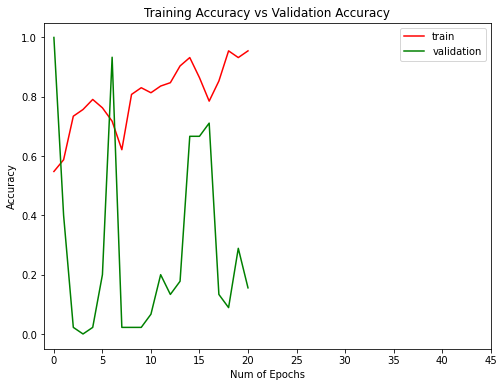

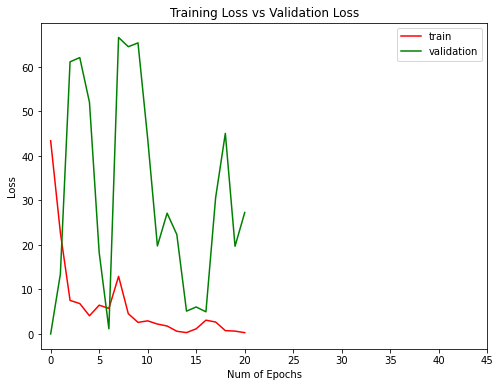

In [42]:
plt.figure(0)  
plt.plot(history_inceptionv3.history['accuracy'],'r')  
plt.plot(history_inceptionv3.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_inceptionv3.history['loss'],'r')  
plt.plot(history_inceptionv3.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

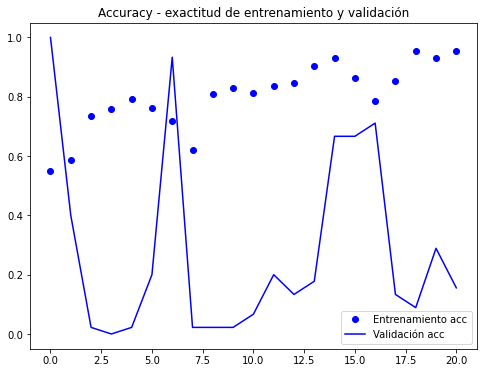

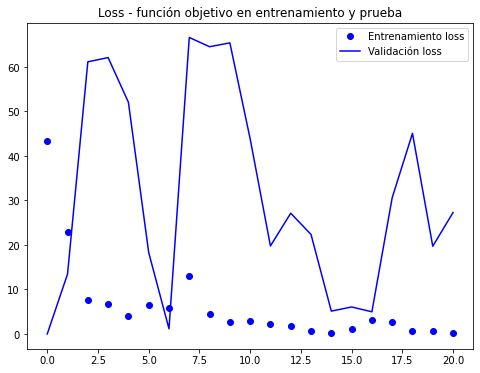

In [43]:
acc      = history_inceptionv3.history['accuracy']
val_acc  = history_inceptionv3.history['val_accuracy']
loss     = history_inceptionv3.history['loss']
val_loss = history_inceptionv3.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [44]:
history_inceptionv3_bis = trasnferLearning_classweight('samsung', InceptionV3)

Epoch 1/200
6/6 [==============================] - 7s 525ms/step - loss: 37.6897 - accuracy: 0.5824 - val_loss: 1.7115 - val_accuracy: 0.5652
Epoch 2/200
6/6 [==============================] - 2s 290ms/step - loss: 1.6056 - accuracy: 0.6319 - val_loss: 3.2492 - val_accuracy: 0.2391
Epoch 3/200
6/6 [==============================] - 2s 327ms/step - loss: 1.2713 - accuracy: 0.6593 - val_loss: 2.4148 - val_accuracy: 0.3043
Epoch 4/200
6/6 [==============================] - 2s 327ms/step - loss: 1.0970 - accuracy: 0.7143 - val_loss: 8.5532 - val_accuracy: 0.0217
Epoch 5/200
6/6 [==============================] - 2s 325ms/step - loss: 1.5327 - accuracy: 0.6703 - val_loss: 9.4754 - val_accuracy: 0.0217
Epoch 6/200
6/6 [==============================] - 2s 325ms/step - loss: 1.3269 - accuracy: 0.6978 - val_loss: 7.0236 - val_accuracy: 0.0435
Epoch 7/200
6/6 [==============================] - 2s 337ms/step - loss: 0.6696 - accuracy: 0.7473 - val_loss: 1.4220 - val_accuracy: 0.6304
Epoch 8/200


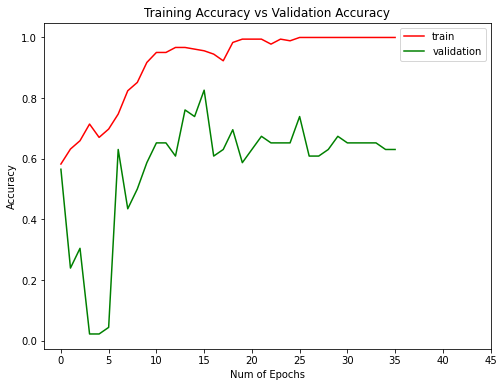

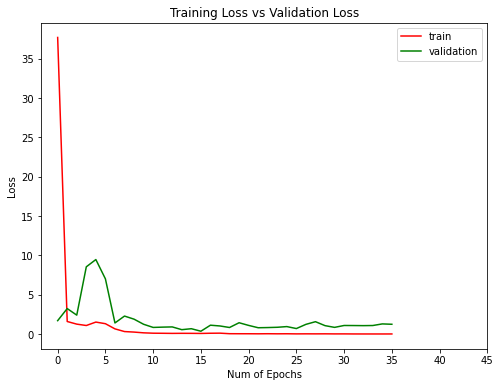

In [45]:
plt.figure(0)  
plt.plot(history_inceptionv3_bis.history['accuracy'],'r')  
plt.plot(history_inceptionv3_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_inceptionv3_bis.history['loss'],'r')  
plt.plot(history_inceptionv3_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

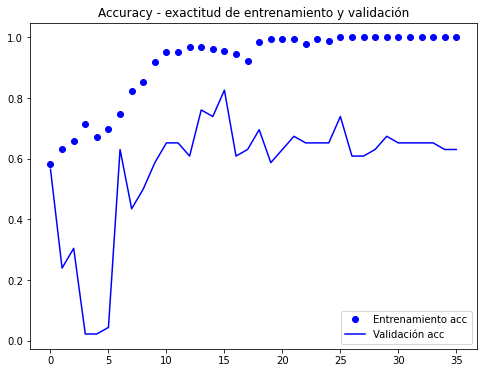

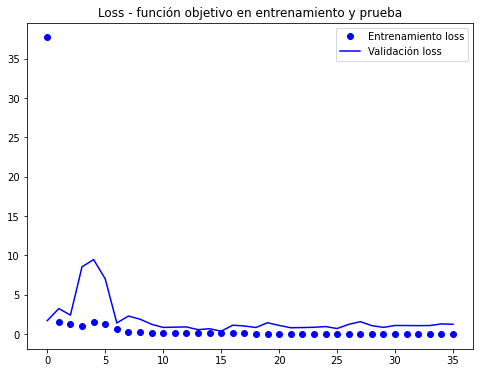

In [46]:
acc      = history_inceptionv3_bis.history['accuracy']
val_acc  = history_inceptionv3_bis.history['val_accuracy']
loss     = history_inceptionv3_bis.history['loss']
val_loss = history_inceptionv3_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

 ## InceptionResNetV2

In [47]:
history_inceptionresnetv2 = trasnferLearning_classweight('iphone', InceptionResNetV2)

Epoch 1/200
6/6 [==============================] - 58s 4s/step - loss: 56.3632 - accuracy: 0.4689 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 16.8981 - accuracy: 0.5254 - val_loss: 49.3488 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 5.2844 - accuracy: 0.5876 - val_loss: 15.3630 - val_accuracy: 0.2444
Epoch 4/200
6/6 [==============================] - 9s 2s/step - loss: 4.4739 - accuracy: 0.6723 - val_loss: 39.2589 - val_accuracy: 0.0444
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 4.5424 - accuracy: 0.6045 - val_loss: 58.2411 - val_accuracy: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 11.9818 - accuracy: 0.5650 - val_loss: 71.9817 - val_accuracy: 0.0000e+00
Epoch 7/200
6/6 [==============================] - 9s 1s/step - loss: 17.2093 - accuracy: 0.4407 - val_loss: 88.8458 - val_accuracy: 0.0000e+00
Epo

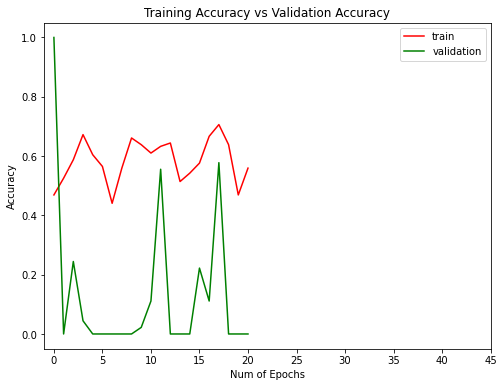

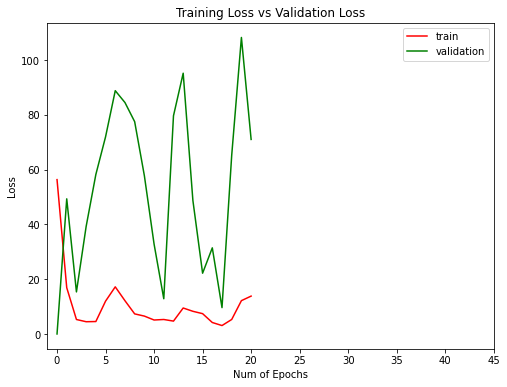

In [48]:
plt.figure(0)  
plt.plot(history_inceptionresnetv2.history['accuracy'],'r')  
plt.plot(history_inceptionresnetv2.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_inceptionresnetv2.history['loss'],'r')  
plt.plot(history_inceptionresnetv2.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

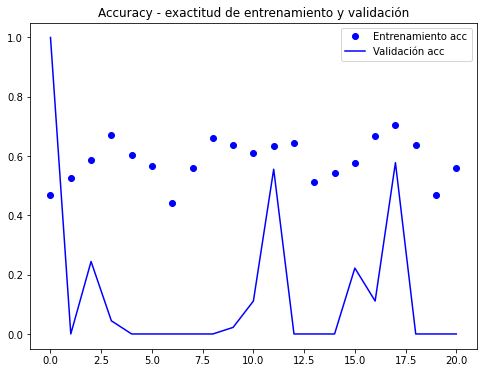

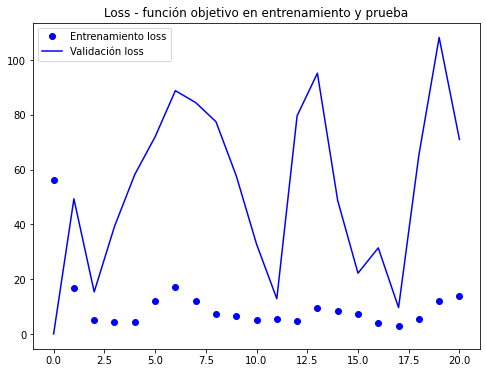

In [49]:
acc      = history_inceptionresnetv2.history['accuracy']
val_acc  = history_inceptionresnetv2.history['val_accuracy']
loss     = history_inceptionresnetv2.history['loss']
val_loss = history_inceptionresnetv2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [50]:
history_inceptionresnetv2_bis = trasnferLearning_classweight('samsung', InceptionResNetV2)

Epoch 1/200
6/6 [==============================] - 57s 4s/step - loss: 88.8335 - accuracy: 0.5495 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/200
6/6 [==============================] - 9s 2s/step - loss: 25.1998 - accuracy: 0.6868 - val_loss: 23.9396 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 9s 2s/step - loss: 10.7870 - accuracy: 0.4121 - val_loss: 0.1014 - val_accuracy: 0.9783
Epoch 4/200
6/6 [==============================] - 9s 2s/step - loss: 11.5481 - accuracy: 0.3571 - val_loss: 0.1015 - val_accuracy: 0.9348
Epoch 5/200
6/6 [==============================] - 10s 2s/step - loss: 7.1656 - accuracy: 0.5495 - val_loss: 24.8976 - val_accuracy: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 9s 2s/step - loss: 6.1382 - accuracy: 0.6154 - val_loss: 17.2509 - val_accuracy: 0.0217
Epoch 7/200
6/6 [==============================] - 8s 1s/step - loss: 3.6080 - accuracy: 0.5110 - val_loss: 11.3081 - val_accuracy: 0.0000e+00
Epoch 8/

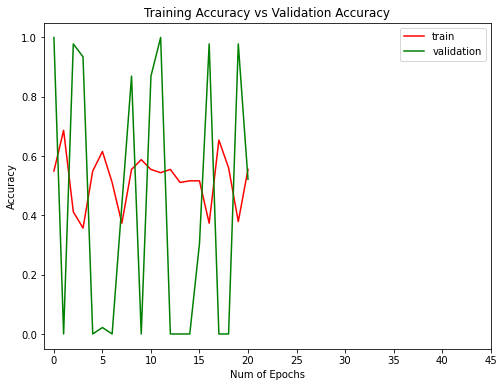

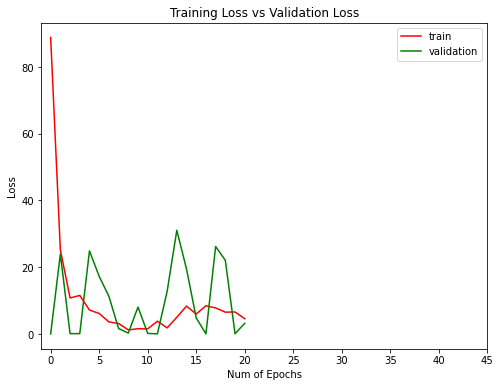

In [51]:
plt.figure(0)  
plt.plot(history_inceptionresnetv2_bis.history['accuracy'],'r')  
plt.plot(history_inceptionresnetv2_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_inceptionresnetv2_bis.history['loss'],'r')  
plt.plot(history_inceptionresnetv2_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

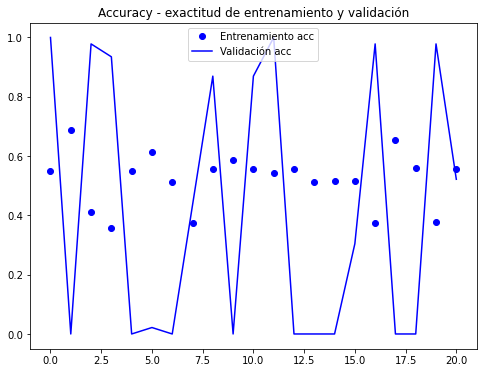

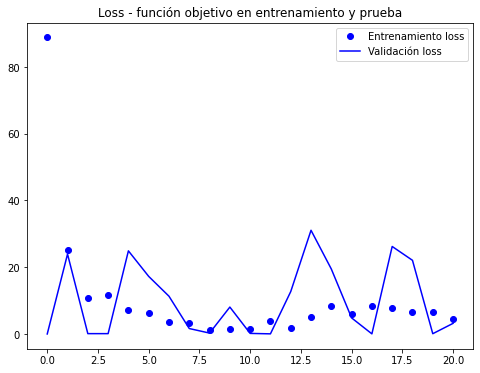

In [52]:
acc      = history_inceptionresnetv2_bis.history['accuracy']
val_acc  = history_inceptionresnetv2_bis.history['val_accuracy']
loss     = history_inceptionresnetv2_bis.history['loss']
val_loss = history_inceptionresnetv2_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## MobileNet

In [53]:
history_mobilenet = trasnferLearning_classweight('samsung', MobileNet)

Epoch 1/200
6/6 [==============================] - 10s 843ms/step - loss: 1.4875 - accuracy: 0.5549 - val_loss: 4.6578 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 2s 378ms/step - loss: 0.9213 - accuracy: 0.6703 - val_loss: 2.7549 - val_accuracy: 0.0652
Epoch 3/200
6/6 [==============================] - 3s 463ms/step - loss: 0.4018 - accuracy: 0.7912 - val_loss: 0.5067 - val_accuracy: 0.7826
Epoch 4/200
6/6 [==============================] - 2s 408ms/step - loss: 0.3186 - accuracy: 0.8516 - val_loss: 1.2673 - val_accuracy: 0.3913
Epoch 5/200
6/6 [==============================] - 2s 319ms/step - loss: 0.2144 - accuracy: 0.9176 - val_loss: 2.2463 - val_accuracy: 0.2826
Epoch 6/200
6/6 [==============================] - 3s 451ms/step - loss: 0.1721 - accuracy: 0.8901 - val_loss: 0.4175 - val_accuracy: 0.8043
Epoch 7/200
6/6 [==============================] - 2s 401ms/step - loss: 0.0925 - accuracy: 0.9835 - val_loss: 2.1525 - val_accuracy: 0.2826
Epoch 8/

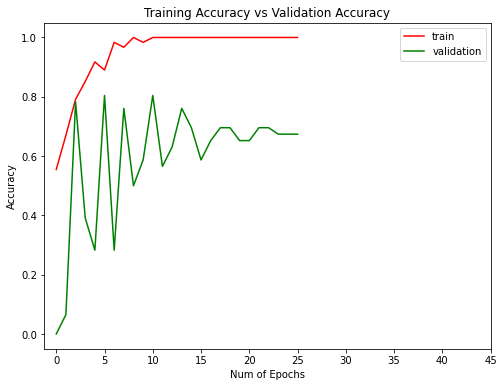

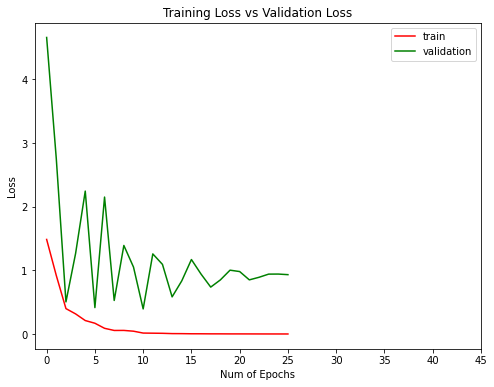

In [54]:
plt.figure(0)  
plt.plot(history_mobilenet.history['accuracy'],'r')  
plt.plot(history_mobilenet.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_mobilenet.history['loss'],'r')  
plt.plot(history_mobilenet.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

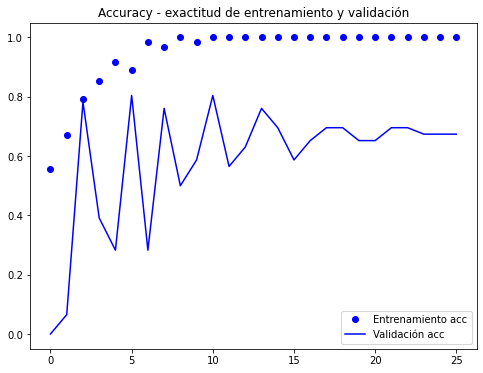

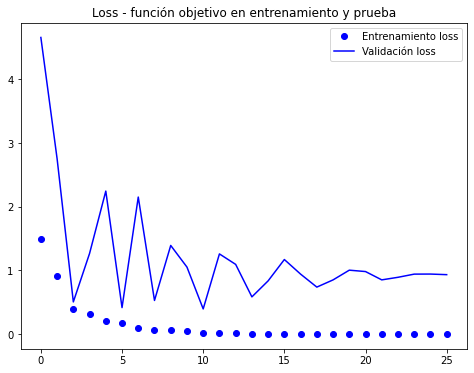

In [55]:
acc      = history_mobilenet.history['accuracy']
val_acc  = history_mobilenet.history['val_accuracy']
loss     = history_mobilenet.history['loss']
val_loss = history_mobilenet.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [56]:
history_mobilenet_bis = trasnferLearning_classweight('iphone', MobileNet)

Epoch 1/200
6/6 [==============================] - 8s 534ms/step - loss: 2.5744 - accuracy: 0.5254 - val_loss: 4.0576 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 2s 302ms/step - loss: 0.5687 - accuracy: 0.7684 - val_loss: 3.7546 - val_accuracy: 0.0444
Epoch 3/200
6/6 [==============================] - 2s 260ms/step - loss: 0.3069 - accuracy: 0.8644 - val_loss: 2.3289 - val_accuracy: 0.1333
Epoch 4/200
6/6 [==============================] - 2s 266ms/step - loss: 0.1826 - accuracy: 0.9492 - val_loss: 2.8141 - val_accuracy: 0.0667
Epoch 5/200
6/6 [==============================] - 2s 263ms/step - loss: 0.0952 - accuracy: 0.9944 - val_loss: 2.1212 - val_accuracy: 0.1333
Epoch 6/200
6/6 [==============================] - 1s 236ms/step - loss: 0.0609 - accuracy: 1.0000 - val_loss: 3.1152 - val_accuracy: 0.0889
Epoch 7/200
6/6 [==============================] - 1s 241ms/step - loss: 0.0440 - accuracy: 1.0000 - val_loss: 2.6446 - val_accuracy: 0.1333
Epoch 8/2

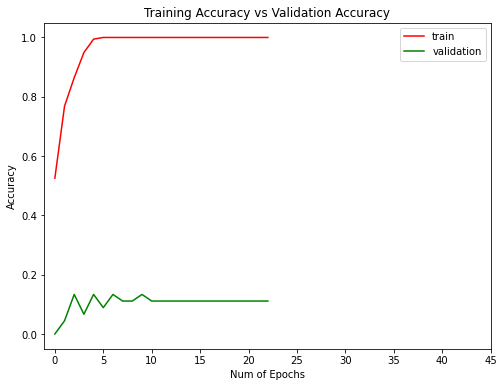

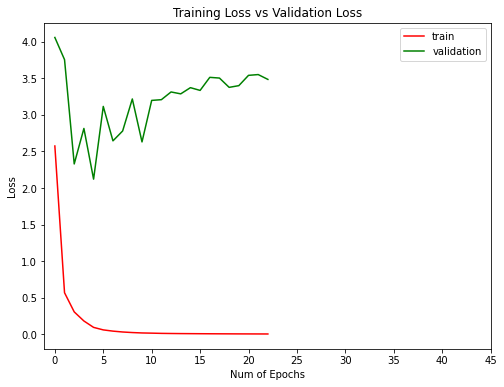

In [57]:
plt.figure(0)  
plt.plot(history_mobilenet_bis.history['accuracy'],'r')  
plt.plot(history_mobilenet_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_mobilenet_bis.history['loss'],'r')  
plt.plot(history_mobilenet_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

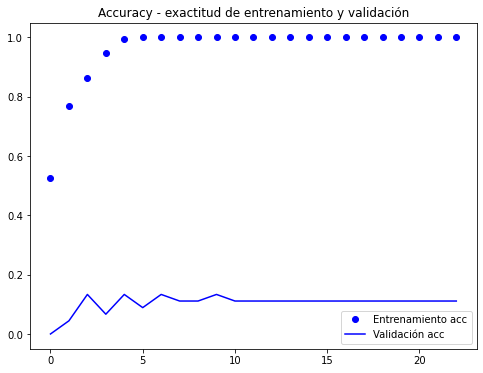

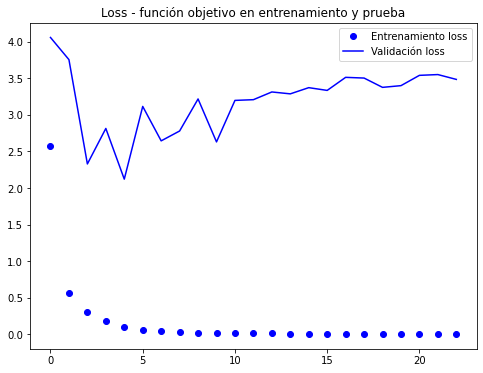

In [58]:
acc      = history_mobilenet_bis.history['accuracy']
val_acc  = history_mobilenet_bis.history['val_accuracy']
loss     = history_mobilenet_bis.history['loss']
val_loss = history_mobilenet_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## DenseNet121

In [59]:
history_densenet121 = trasnferLearning_classweight('iphone', DenseNet121)

Epoch 1/200
6/6 [==============================] - 19s 1s/step - loss: 10.8086 - accuracy: 0.4746 - val_loss: 11.8711 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 5s 782ms/step - loss: 1.6274 - accuracy: 0.6328 - val_loss: 4.0876 - val_accuracy: 0.0222
Epoch 3/200
6/6 [==============================] - 5s 788ms/step - loss: 1.0101 - accuracy: 0.6554 - val_loss: 2.1077 - val_accuracy: 0.0889
Epoch 4/200
6/6 [==============================] - 5s 873ms/step - loss: 0.5656 - accuracy: 0.7458 - val_loss: 3.7128 - val_accuracy: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 5s 819ms/step - loss: 0.5713 - accuracy: 0.7345 - val_loss: 1.6540 - val_accuracy: 0.2000
Epoch 6/200
6/6 [==============================] - 5s 811ms/step - loss: 0.5450 - accuracy: 0.7401 - val_loss: 1.5513 - val_accuracy: 0.2222
Epoch 7/200
6/6 [==============================] - 5s 801ms/step - loss: 0.4453 - accuracy: 0.8362 - val_loss: 4.4778 - val_accuracy: 0.0222
Epoch

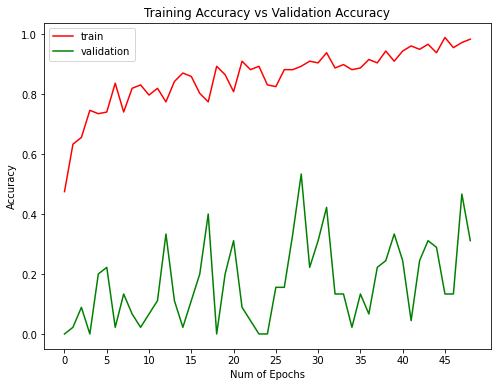

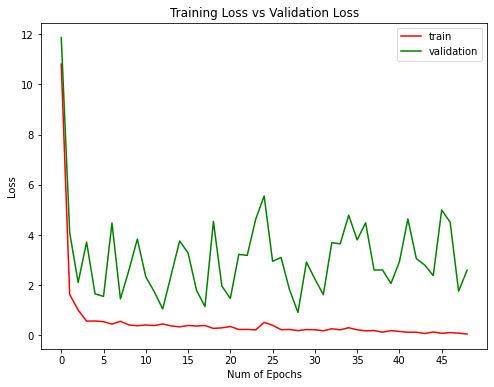

In [60]:
plt.figure(0)  
plt.plot(history_densenet121.history['accuracy'],'r')  
plt.plot(history_densenet121.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_densenet121.history['loss'],'r')  
plt.plot(history_densenet121.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

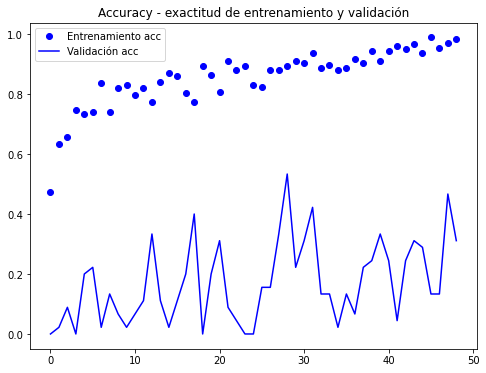

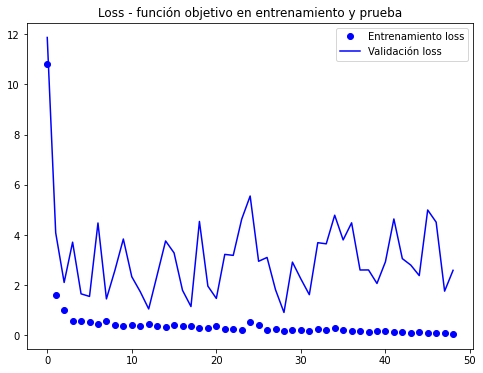

In [61]:
acc      = history_densenet121.history['accuracy']
val_acc  = history_densenet121.history['val_accuracy']
loss     = history_densenet121.history['loss']
val_loss = history_densenet121.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [62]:
history_densenet121_bis = trasnferLearning_classweight('samsung', DenseNet121)

Epoch 1/200
6/6 [==============================] - 12s 1s/step - loss: 11.2890 - accuracy: 0.4725 - val_loss: 19.3189 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 5s 805ms/step - loss: 4.1846 - accuracy: 0.5714 - val_loss: 12.2282 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 5s 853ms/step - loss: 1.8114 - accuracy: 0.6374 - val_loss: 4.4986 - val_accuracy: 0.0652
Epoch 4/200
6/6 [==============================] - 5s 848ms/step - loss: 0.9334 - accuracy: 0.6429 - val_loss: 2.6974 - val_accuracy: 0.1739
Epoch 5/200
6/6 [==============================] - 5s 815ms/step - loss: 0.6342 - accuracy: 0.6648 - val_loss: 0.7021 - val_accuracy: 0.6739
Epoch 6/200
6/6 [==============================] - 5s 823ms/step - loss: 0.6114 - accuracy: 0.7473 - val_loss: 2.8353 - val_accuracy: 0.0217
Epoch 7/200
6/6 [==============================] - 5s 814ms/step - loss: 0.6919 - accuracy: 0.6868 - val_loss: 1.8406 - val_accuracy: 0.2826
Epoc

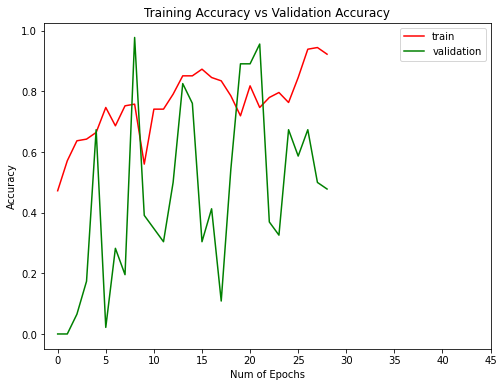

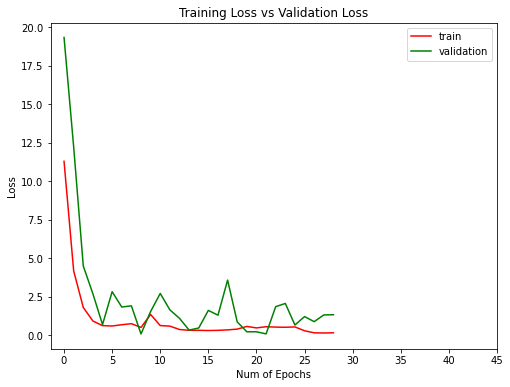

In [63]:
plt.figure(0)  
plt.plot(history_densenet121_bis.history['accuracy'],'r')  
plt.plot(history_densenet121_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_densenet121_bis.history['loss'],'r')  
plt.plot(history_densenet121_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

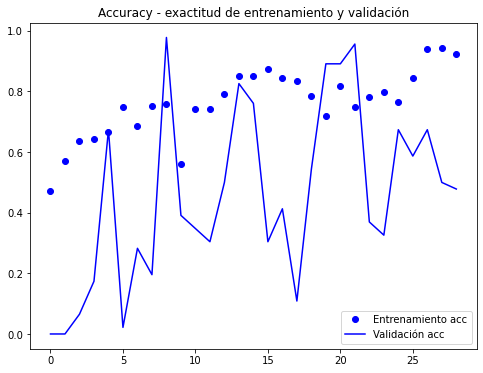

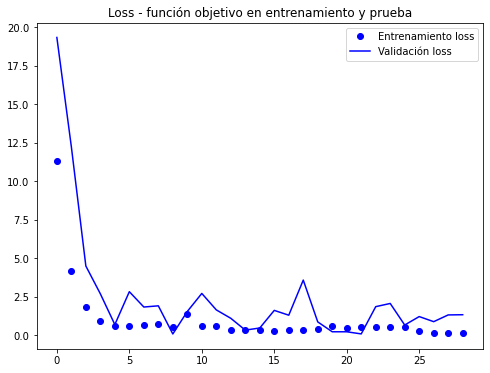

In [64]:
acc      = history_densenet121_bis.history['accuracy']
val_acc  = history_densenet121_bis.history['val_accuracy']
loss     = history_densenet121_bis.history['loss']
val_loss = history_densenet121_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## DenseNet201

In [65]:
history_densenet201 = trasnferLearning_classweight('iphone', DenseNet201)

Epoch 1/200
6/6 [==============================] - 21s 2s/step - loss: 25.4793 - accuracy: 0.4520 - val_loss: 37.4427 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 6s 1s/step - loss: 10.6807 - accuracy: 0.4915 - val_loss: 13.4615 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 7s 1s/step - loss: 5.0312 - accuracy: 0.6215 - val_loss: 1.1114 - val_accuracy: 0.5556
Epoch 4/200
6/6 [==============================] - 7s 1s/step - loss: 6.8280 - accuracy: 0.5593 - val_loss: 24.2500 - val_accuracy: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 7s 1s/step - loss: 4.3774 - accuracy: 0.7514 - val_loss: 47.4101 - val_accuracy: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 7s 1s/step - loss: 3.0718 - accuracy: 0.7401 - val_loss: 19.3111 - val_accuracy: 0.0222
Epoch 7/200
6/6 [==============================] - 7s 1s/step - loss: 2.4770 - accuracy: 0.7288 - val_loss: 2.0177 - val_accuracy: 0.5333
Epoch 8/20

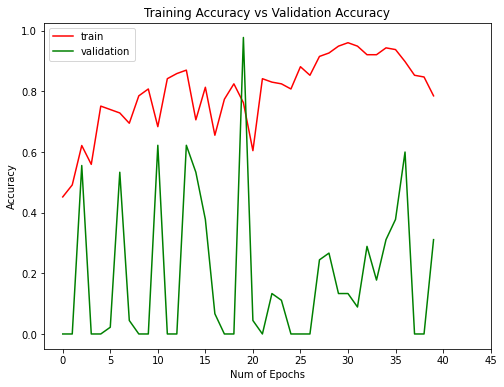

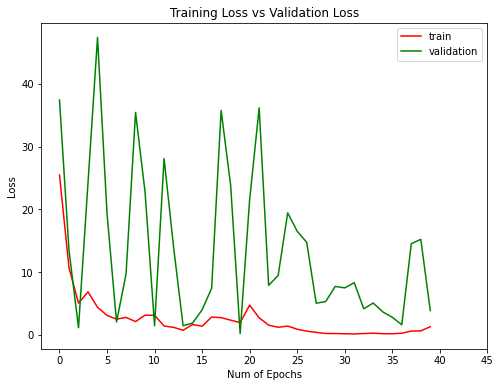

In [66]:
plt.figure(0)  
plt.plot(history_densenet201.history['accuracy'],'r')  
plt.plot(history_densenet201.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_densenet201.history['loss'],'r')  
plt.plot(history_densenet201.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

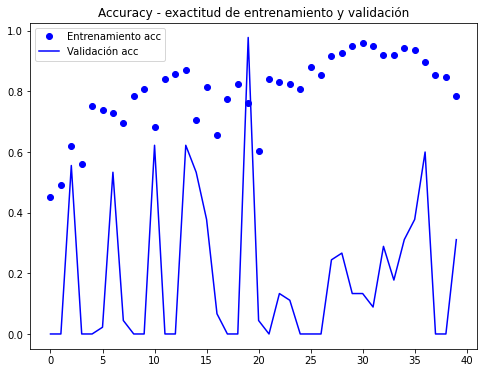

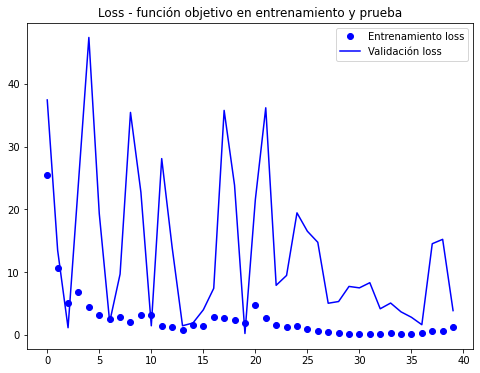

In [67]:
acc      = history_densenet201.history['accuracy']
val_acc  = history_densenet201.history['val_accuracy']
loss     = history_densenet201.history['loss']
val_loss = history_densenet201.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [68]:
history_densenet201_bis = trasnferLearning_classweight('samsung', DenseNet201)

Epoch 1/200
6/6 [==============================] - 24s 2s/step - loss: 22.2627 - accuracy: 0.3956 - val_loss: 5.5452e-06 - val_accuracy: 1.0000
Epoch 2/200
6/6 [==============================] - 7s 1s/step - loss: 8.8720 - accuracy: 0.5879 - val_loss: 18.4756 - val_accuracy: 0.0217
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 3.4534 - accuracy: 0.6868 - val_loss: 9.1482 - val_accuracy: 0.2826
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 2.7604 - accuracy: 0.6703 - val_loss: 17.6462 - val_accuracy: 0.0217
Epoch 5/200
6/6 [==============================] - 8s 1s/step - loss: 5.0841 - accuracy: 0.4670 - val_loss: 0.2653 - val_accuracy: 0.8913
Epoch 6/200
6/6 [==============================] - 8s 1s/step - loss: 3.1558 - accuracy: 0.5934 - val_loss: 0.0963 - val_accuracy: 0.9783
Epoch 7/200
6/6 [==============================] - 8s 1s/step - loss: 3.0487 - accuracy: 0.5385 - val_loss: 0.1192 - val_accuracy: 0.9348
Epoch 8/200
6/6 [=========

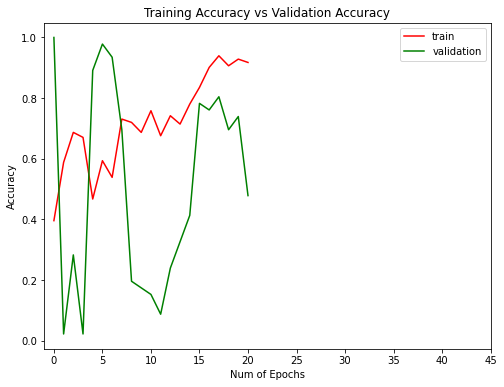

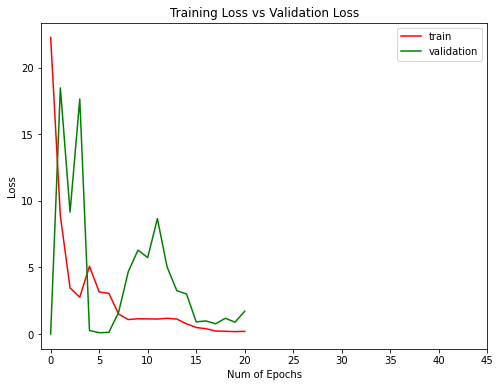

In [69]:
plt.figure(0)  
plt.plot(history_densenet201_bis.history['accuracy'],'r')  
plt.plot(history_densenet201_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_densenet201_bis.history['loss'],'r')  
plt.plot(history_densenet201_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

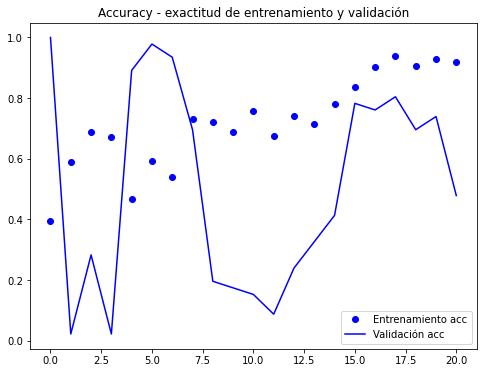

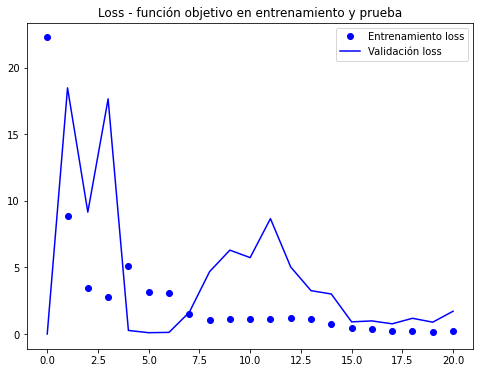

In [70]:
acc      = history_densenet201_bis.history['accuracy']
val_acc  = history_densenet201_bis.history['val_accuracy']
loss     = history_densenet201_bis.history['loss']
val_loss = history_densenet201_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## EfficientNetB0

In [71]:
history_efficientnetb0 = trasnferLearning_classweight('iphone', EfficientNetB0)

Epoch 1/200
6/6 [==============================] - 10s 765ms/step - loss: 1.4795 - accuracy: 0.5198 - val_loss: 1.6634 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 3s 466ms/step - loss: 0.5904 - accuracy: 0.5876 - val_loss: 2.7219 - val_accuracy: 0.0444
Epoch 3/200
6/6 [==============================] - 3s 469ms/step - loss: 0.5323 - accuracy: 0.7910 - val_loss: 2.0382 - val_accuracy: 0.1556
Epoch 4/200
6/6 [==============================] - 3s 461ms/step - loss: 0.4008 - accuracy: 0.8136 - val_loss: 3.1441 - val_accuracy: 0.0444
Epoch 5/200
6/6 [==============================] - 3s 460ms/step - loss: 0.3395 - accuracy: 0.8362 - val_loss: 2.0820 - val_accuracy: 0.0889
Epoch 6/200
6/6 [==============================] - 3s 470ms/step - loss: 0.2596 - accuracy: 0.8870 - val_loss: 2.5339 - val_accuracy: 0.1333
Epoch 7/200
6/6 [==============================] - 3s 467ms/step - loss: 0.2192 - accuracy: 0.9322 - val_loss: 2.4996 - val_accuracy: 0.1333
Epoch 8/

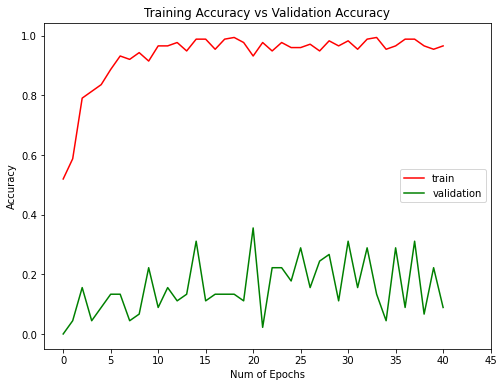

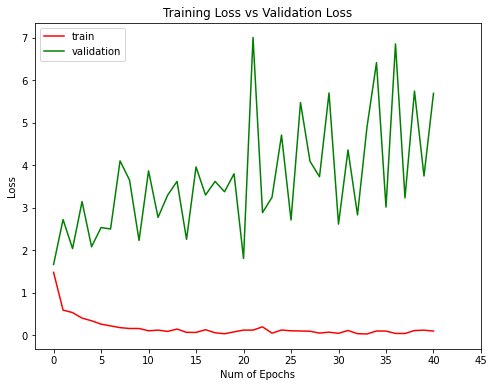

In [72]:
plt.figure(0)  
plt.plot(history_efficientnetb0.history['accuracy'],'r')  
plt.plot(history_efficientnetb0.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_efficientnetb0.history['loss'],'r')  
plt.plot(history_efficientnetb0.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

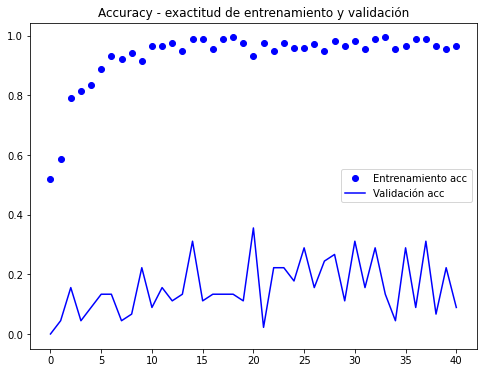

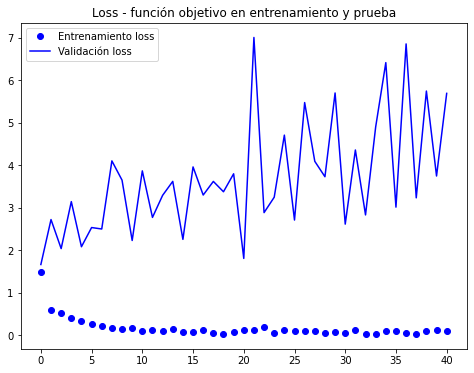

In [73]:
acc      = history_efficientnetb0.history['accuracy']
val_acc  = history_efficientnetb0.history['val_accuracy']
loss     = history_efficientnetb0.history['loss']
val_loss = history_efficientnetb0.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [74]:
history_efficientnetb0_bis = trasnferLearning_classweight('samsung', EfficientNetB0)

Epoch 1/200
6/6 [==============================] - 11s 778ms/step - loss: 1.0767 - accuracy: 0.4176 - val_loss: 0.1681 - val_accuracy: 1.0000
Epoch 2/200
6/6 [==============================] - 3s 483ms/step - loss: 0.8960 - accuracy: 0.5714 - val_loss: 0.7886 - val_accuracy: 0.5435
Epoch 3/200
6/6 [==============================] - 3s 470ms/step - loss: 0.6047 - accuracy: 0.7473 - val_loss: 2.1156 - val_accuracy: 0.0435
Epoch 4/200
6/6 [==============================] - 3s 472ms/step - loss: 0.4100 - accuracy: 0.8297 - val_loss: 0.9579 - val_accuracy: 0.4783
Epoch 5/200
6/6 [==============================] - 3s 481ms/step - loss: 0.3857 - accuracy: 0.7967 - val_loss: 0.4003 - val_accuracy: 0.8478
Epoch 6/200
6/6 [==============================] - 3s 483ms/step - loss: 0.2797 - accuracy: 0.8956 - val_loss: 1.3126 - val_accuracy: 0.3478
Epoch 7/200
6/6 [==============================] - 3s 490ms/step - loss: 0.2776 - accuracy: 0.8901 - val_loss: 1.0964 - val_accuracy: 0.4565
Epoch 8/200


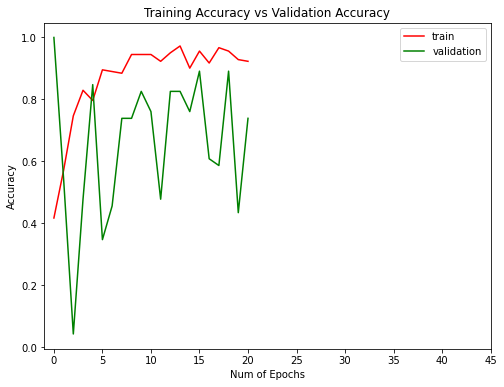

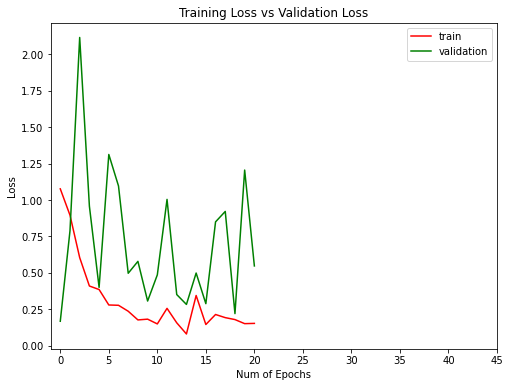

In [75]:
plt.figure(0)  
plt.plot(history_efficientnetb0_bis.history['accuracy'],'r')  
plt.plot(history_efficientnetb0_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_efficientnetb0_bis.history['loss'],'r')  
plt.plot(history_efficientnetb0_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

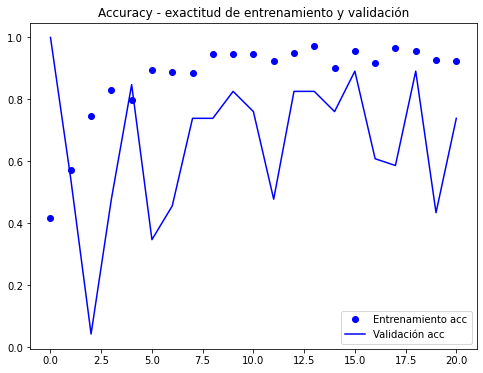

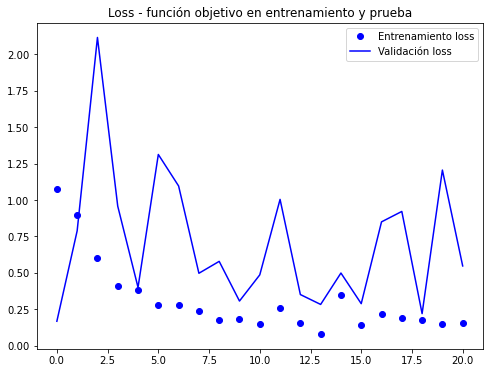

In [76]:
acc      = history_efficientnetb0_bis.history['accuracy']
val_acc  = history_efficientnetb0_bis.history['val_accuracy']
loss     = history_efficientnetb0_bis.history['loss']
val_loss = history_efficientnetb0_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## EfficientNetV2B0

In [77]:
history_efficientnetv2b0 = trasnferLearning_classweight('iphone', EfficientNetV2B0)

Epoch 1/200
6/6 [==============================] - 13s 764ms/step - loss: 1.5403 - accuracy: 0.4068 - val_loss: 1.0659 - val_accuracy: 0.0444
Epoch 2/200
6/6 [==============================] - 3s 469ms/step - loss: 0.6457 - accuracy: 0.6667 - val_loss: 2.0833 - val_accuracy: 0.0667
Epoch 3/200
6/6 [==============================] - 3s 468ms/step - loss: 0.7628 - accuracy: 0.7175 - val_loss: 3.8811 - val_accuracy: 0.0000e+00
Epoch 4/200
6/6 [==============================] - 3s 464ms/step - loss: 0.4986 - accuracy: 0.7910 - val_loss: 2.0199 - val_accuracy: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 3s 467ms/step - loss: 0.4834 - accuracy: 0.7627 - val_loss: 3.2417 - val_accuracy: 0.0000e+00
Epoch 6/200
6/6 [==============================] - 3s 466ms/step - loss: 0.4469 - accuracy: 0.8023 - val_loss: 2.8043 - val_accuracy: 0.0222
Epoch 7/200
6/6 [==============================] - 3s 478ms/step - loss: 0.3842 - accuracy: 0.8192 - val_loss: 1.6374 - val_accuracy: 0.1556


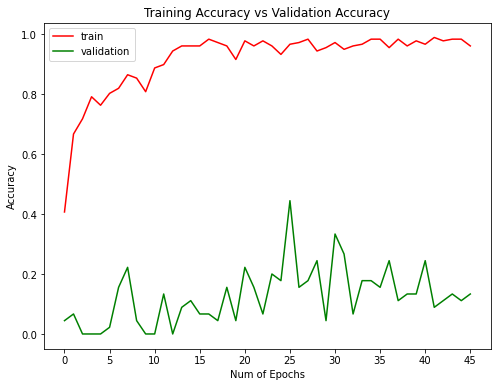

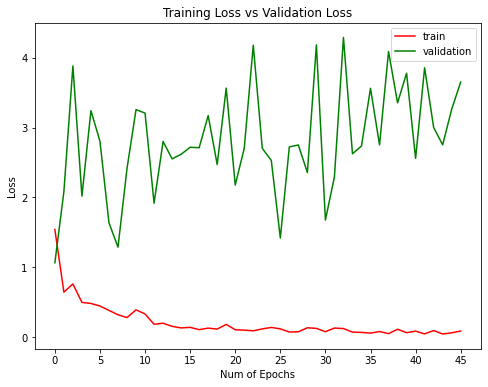

In [78]:
plt.figure(0)  
plt.plot(history_efficientnetv2b0.history['accuracy'],'r')  
plt.plot(history_efficientnetv2b0.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_efficientnetv2b0.history['loss'],'r')  
plt.plot(history_efficientnetv2b0.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

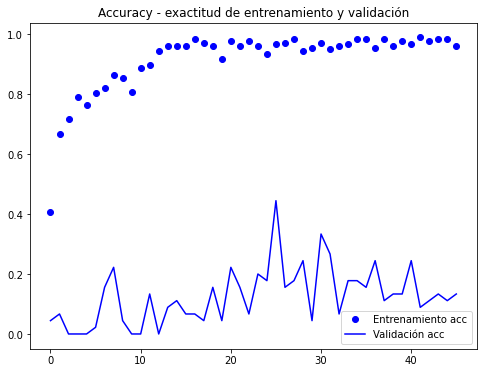

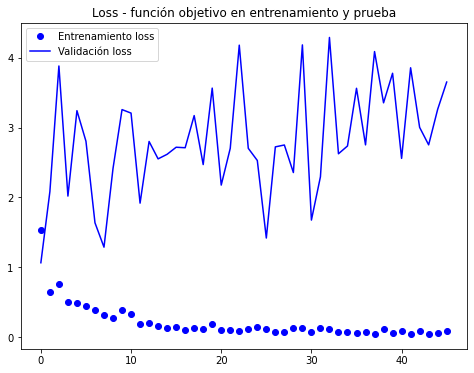

In [79]:
acc      = history_efficientnetv2b0.history['accuracy']
val_acc  = history_efficientnetv2b0.history['val_accuracy']
loss     = history_efficientnetv2b0.history['loss']
val_loss = history_efficientnetv2b0.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [80]:
history_efficientnetv2b0_bis = trasnferLearning_classweight('samsung', EfficientNetV2B0)

Epoch 1/200
6/6 [==============================] - 11s 810ms/step - loss: 2.3402 - accuracy: 0.4615 - val_loss: 1.4401 - val_accuracy: 0.0435
Epoch 2/200
6/6 [==============================] - 3s 475ms/step - loss: 0.9968 - accuracy: 0.5330 - val_loss: 0.9602 - val_accuracy: 0.4130
Epoch 3/200
6/6 [==============================] - 3s 487ms/step - loss: 0.8559 - accuracy: 0.5055 - val_loss: 0.3322 - val_accuracy: 0.9348
Epoch 4/200
6/6 [==============================] - 3s 493ms/step - loss: 1.1046 - accuracy: 0.7088 - val_loss: 4.9704 - val_accuracy: 0.0000e+00
Epoch 5/200
6/6 [==============================] - 3s 507ms/step - loss: 1.0281 - accuracy: 0.5385 - val_loss: 0.2305 - val_accuracy: 0.9783
Epoch 6/200
6/6 [==============================] - 3s 503ms/step - loss: 0.6985 - accuracy: 0.6538 - val_loss: 2.1501 - val_accuracy: 0.0870
Epoch 7/200
6/6 [==============================] - 3s 502ms/step - loss: 0.4743 - accuracy: 0.8022 - val_loss: 0.9529 - val_accuracy: 0.5000
Epoch 8/

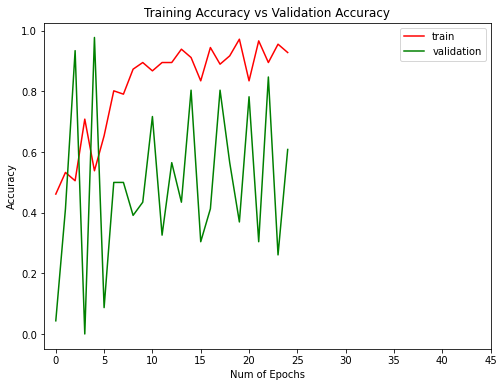

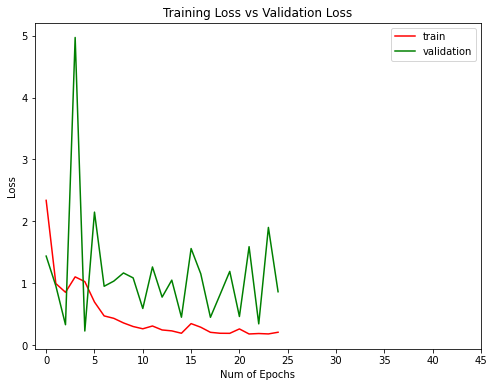

In [81]:
plt.figure(0)  
plt.plot(history_efficientnetv2b0_bis.history['accuracy'],'r')  
plt.plot(history_efficientnetv2b0_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_efficientnetv2b0_bis.history['loss'],'r')  
plt.plot(history_efficientnetv2b0_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

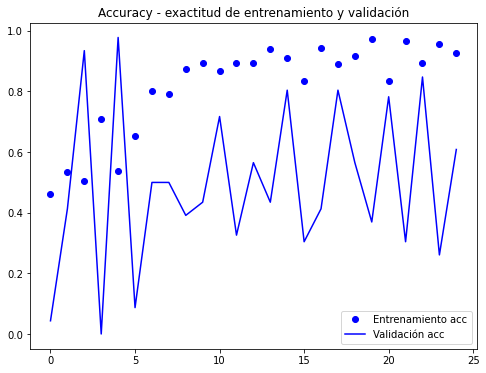

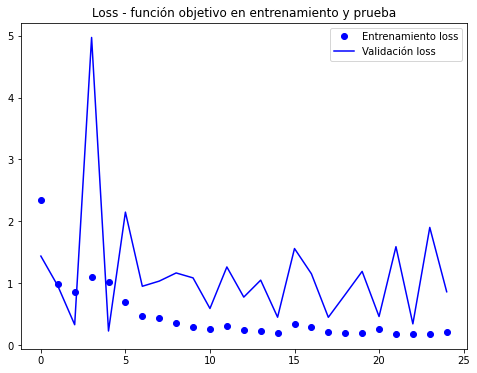

In [82]:
acc      = history_efficientnetv2b0_bis.history['accuracy']
val_acc  = history_efficientnetv2b0_bis.history['val_accuracy']
loss     = history_efficientnetv2b0_bis.history['loss']
val_loss = history_efficientnetv2b0_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

## ConvNeXtTiny

In [83]:
history_convnextiny = trasnferLearning_classweight('iphone', ConvNeXtTiny)

Epoch 1/200
6/6 [==============================] - 59s 9s/step - loss: 0.9727 - accuracy: 0.6158 - val_loss: 1.1642 - val_accuracy: 0.0667
Epoch 2/200
6/6 [==============================] - 45s 8s/step - loss: 0.6847 - accuracy: 0.4689 - val_loss: 2.1471 - val_accuracy: 0.0000e+00
Epoch 3/200
6/6 [==============================] - 42s 7s/step - loss: 0.4866 - accuracy: 0.6893 - val_loss: 1.6619 - val_accuracy: 0.0444
Epoch 4/200
6/6 [==============================] - 45s 8s/step - loss: 0.4291 - accuracy: 0.8418 - val_loss: 1.9658 - val_accuracy: 0.0444
Epoch 5/200
6/6 [==============================] - 41s 7s/step - loss: 0.3210 - accuracy: 0.8983 - val_loss: 2.2512 - val_accuracy: 0.1111
Epoch 6/200
6/6 [==============================] - 41s 7s/step - loss: 0.2624 - accuracy: 0.9096 - val_loss: 2.2545 - val_accuracy: 0.0889
Epoch 7/200
6/6 [==============================] - 44s 8s/step - loss: 0.2761 - accuracy: 0.8701 - val_loss: 2.6723 - val_accuracy: 0.0667
Epoch 8/200
6/6 [======

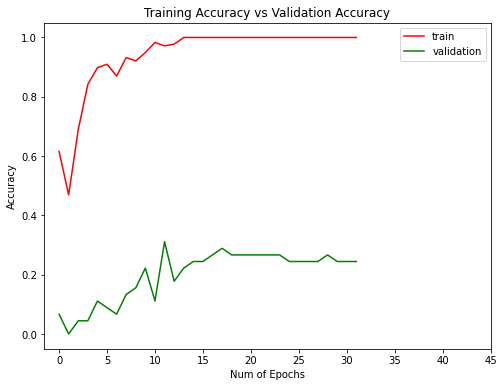

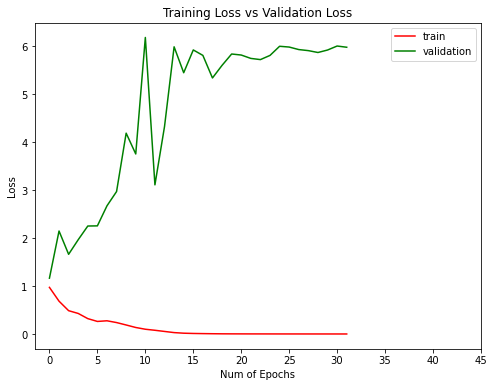

In [84]:
plt.figure(0)  
plt.plot(history_convnextiny.history['accuracy'],'r')  
plt.plot(history_convnextiny.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_convnextiny.history['loss'],'r')  
plt.plot(history_convnextiny.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

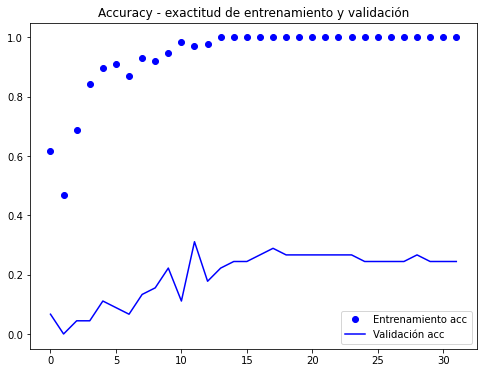

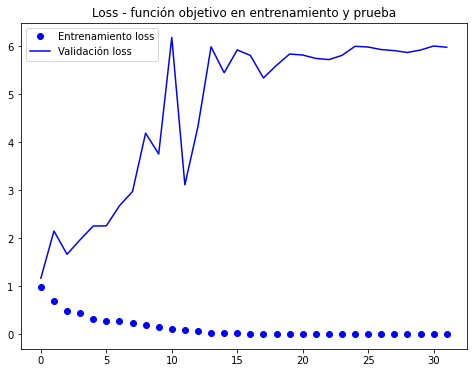

In [85]:
acc      = history_convnextiny.history['accuracy']
val_acc  = history_convnextiny.history['val_accuracy']
loss     = history_convnextiny.history['loss']
val_loss = history_convnextiny.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

In [89]:
history_convnextiny_bis = trasnferLearning_classweight('samsung', ConvNeXtTiny)

Epoch 1/200
6/6 [==============================] - 68s 10s/step - loss: 1.8236 - accuracy: 0.5769 - val_loss: 1.4440 - val_accuracy: 0.1957
Epoch 2/200
6/6 [==============================] - 57s 10s/step - loss: 0.6645 - accuracy: 0.5110 - val_loss: 0.9062 - val_accuracy: 0.5435
Epoch 3/200
6/6 [==============================] - 56s 10s/step - loss: 0.5464 - accuracy: 0.7473 - val_loss: 1.6560 - val_accuracy: 0.2391
Epoch 4/200
6/6 [==============================] - 57s 10s/step - loss: 0.3369 - accuracy: 0.8846 - val_loss: 0.5447 - val_accuracy: 0.6522
Epoch 5/200
6/6 [==============================] - 61s 11s/step - loss: 0.2153 - accuracy: 0.8736 - val_loss: 1.2077 - val_accuracy: 0.4565
Epoch 6/200
6/6 [==============================] - 62s 11s/step - loss: 0.1254 - accuracy: 0.9725 - val_loss: 0.7819 - val_accuracy: 0.5870
Epoch 7/200
6/6 [==============================] - 55s 9s/step - loss: 0.0742 - accuracy: 0.9945 - val_loss: 1.2590 - val_accuracy: 0.4565
Epoch 8/200
6/6 [====

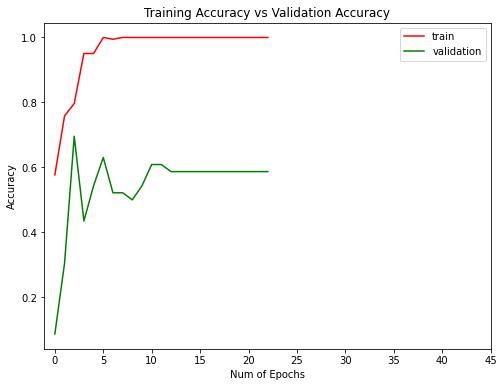

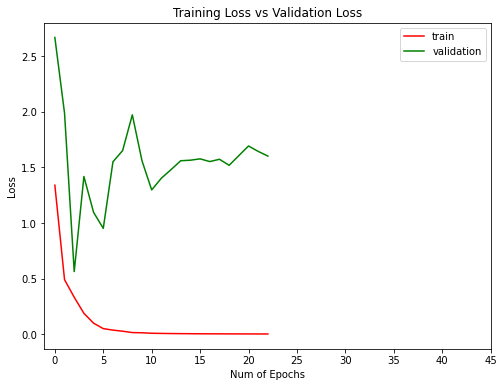

In [87]:
plt.figure(0)  
plt.plot(history_convnextiny_bis.history['accuracy'],'r')  
plt.plot(history_convnextiny_bis.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history_convnextiny_bis.history['loss'],'r')  
plt.plot(history_convnextiny_bis.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

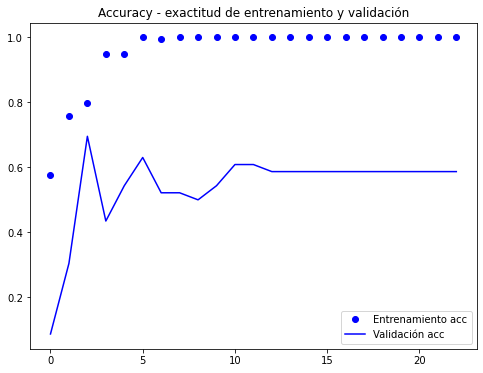

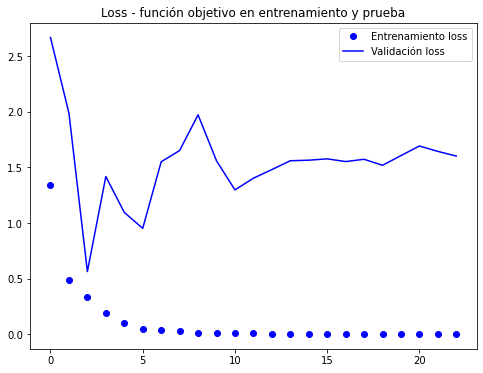

In [88]:
acc      = history_convnextiny_bis.history['accuracy']
val_acc  = history_convnextiny_bis.history['val_accuracy']
loss     = history_convnextiny_bis.history['loss']
val_loss = history_convnextiny_bis.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()